# Abstract 

This report presents several of the deep learning models used and evaluated to perform wind speed forecasting, and it is presented in this Jupyter notebook format so that it serves as an easy-to-apply guide. Python kernel 3.9 was used, and the different neural network models were implemented using Tensorflow and Keras framerworks. It was designed to be self-explanatory. The Nasa Power database was used for the ordinates of Apararecida de Goiânia, Goiás, Brazil.   

# Setup

This notebbok was projected over Python 3.9. The requirements are the follow. 

In [2]:
%%capture
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    SimpleRNN, Flatten, Softmax, ReLU, Multiply,
    Reshape, RepeatVector, Input, Add, Attention, 
    Subtract, Dense, GRU, LSTM, Conv1D, Cropping1D,
    BatchNormalization, Activation, Average, LayerNormalization,
    MaxPool1D, Conv1DTranspose, Concatenate, 
    Input, ConvLSTM1D)
import tensorflow as tf
from tensorflow.keras.utils import normalize
from tensorflow.keras.callbacks import ModelCheckpoint
import keras
import h5py
from keras.optimizers import Adam
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
from numba import jit, cuda
import tensorflow_addons as tfa
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
import datetime, os

%load_ext tensorboard
warnings.filterwarnings('ignore')

In [3]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [4]:
print(tf.config.list_physical_devices("GPU"))

gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(
                gpu, True
            )  # Ativa alocação dinâmica de memória
    except RuntimeError as e:
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Dataset pre-processing

In [5]:
''' Function to used with direction features'''

sind = lambda degrees: np.sin(np.deg2rad(degrees))
cosd = lambda degrees: np.cos(np.deg2rad(degrees))

In [10]:
# Link to the CSV file on GitHub
url = 'https://raw.githubusercontent.com/DarioFantini/Furnas-BRAMS/refs/heads/main/POWER_Point_Hourly_20050101_20141231_016d7961S_049d2313W_LST.csv'
# Other data sets: 
# https://raw.githubusercontent.com/DarioFantini/Furnas-BRAMS/refs/heads/main/Fortim-POWER_Point_Hourly_20050101_20141231_004d4154S_037d8167W_LST.csv
# https://raw.githubusercontent.com/DarioFantini/Furnas-BRAMS/refs/heads/main/Itumbiaria_POWER_Point_Hourly_20050101_20141231_018d4084S_049d1010W_LST.csv

In [11]:
ap_data = pd.read_csv(url, 
                      sep=',', header=13) #put it in the same folder or type in the folder path 

#Convert YY-MO-DY columns to datetime format
ap_data.columns = ["Year", "Month", "Day", "Hour", "ALLSKY", "Temp_2m", "Wind Direction", "Wind Speed", "PS"]

#Create a Date column with datetime values and place it as an index
ap_data['Date'] = pd.to_datetime(ap_data[['Year','Month', 'Day', 'Hour']])
ap_data.set_index('Date', inplace=True) # implementar no local ou definir o índice
data_to_sasonal = ap_data.copy() #copies the contents of the df and not the memory location

#Create a DoY (day of year) column with the days of the year and then create a multindex.
ap_data['DoY'] = ap_data.index.dayofyear
ap_data.reset_index(inplace=True)
ap_data.insert(0, 'HoY', (ap_data.DoY-1)*24 + ap_data.Hour)
ap_data.set_index(['DoY', 'HoY', 'Date'], inplace=True) #multindex

# Grouping 
ws_meanxhora = ap_data['Wind Speed'].groupby([ap_data.Year, ap_data.Month, ap_data.Day, ap_data.Hour]).mean().to_frame()
ws_meanxhora.loc[:,'Wind Direction'] = ap_data['Wind Direction'].groupby([ap_data.Year, ap_data.Month, ap_data.Day, ap_data.Hour]).mean().to_frame()
ws_meanxhora.loc[:,'Wind Dir Sin'] = sind(ap_data['Wind Direction']).groupby([ap_data.Year, ap_data.Month, ap_data.Day, ap_data.Hour]).mean().to_frame()
ws_meanxhora.loc[:,'Wind Dir Cos'] = cosd(ap_data['Wind Direction']).groupby([ap_data.Year, ap_data.Month, ap_data.Day, ap_data.Hour]).mean().to_frame()

samples = len(ws_meanxhora)
slide_timeStep = 64
num_features = 1
 
data = np.array(ws_meanxhora[["Wind Speed"]])#, 'Wind Dir Sin', 'Wind Dir Cos']])
#Data_set completo
data_set = np.array([data[i:i+slide_timeStep] for i in range(samples-slide_timeStep)])
#Targets completo  
target_set = data[slide_timeStep:][:, 0]

Inputs_train, Inputs_test, targets_train, targets_test =\
                        train_test_split(data_set, target_set, test_size=0.4, 
                        shuffle=False, random_state=None)
                        
X_train, Y_train = Inputs_train, targets_train.reshape(-1,1)   
X_test, Y_test = Inputs_test, targets_test.reshape(-1,1) 

In [61]:
#Print the time serie wind speed

In [83]:
from statsmodels.tsa.seasonal import seasonal_decompose

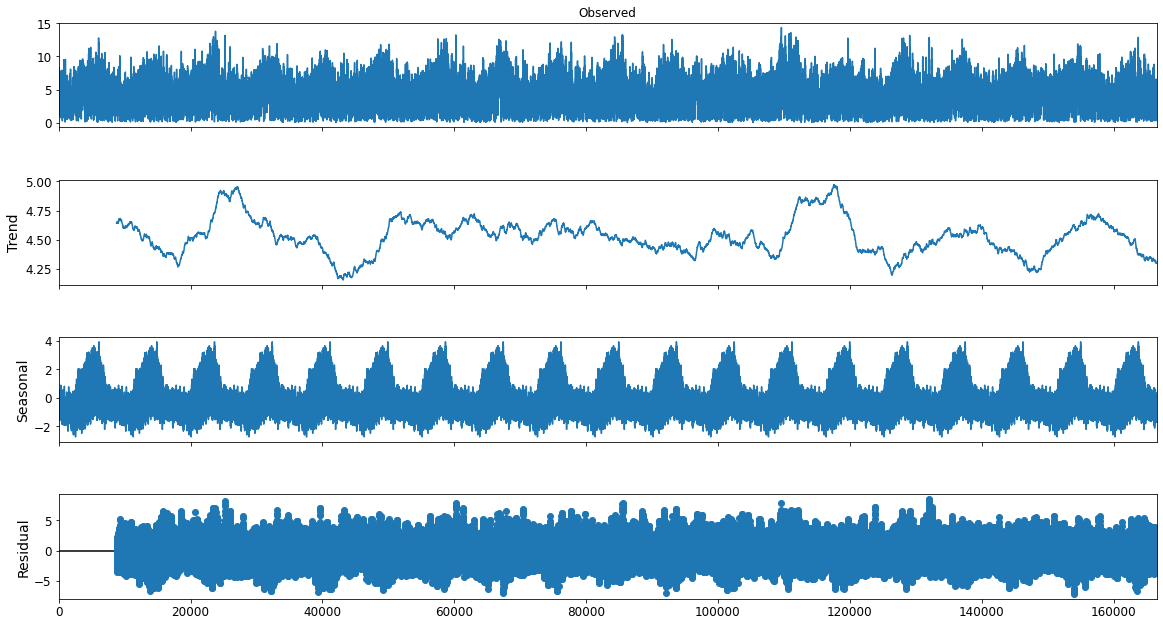

In [63]:
components = seasonal_decompose(data, model='additive', period=8760, two_sided=False)
fig = components.plot()
fig.set_size_inches((19,10))

In [64]:
components.observed.var()

4.751639017596351

In [65]:
components.seasonal.var()

1.6878153225202195

In [66]:
components.trend[8760:].var()

0.023107097805738216

In [67]:
components.resid[8760:].var()

3.080074281000177

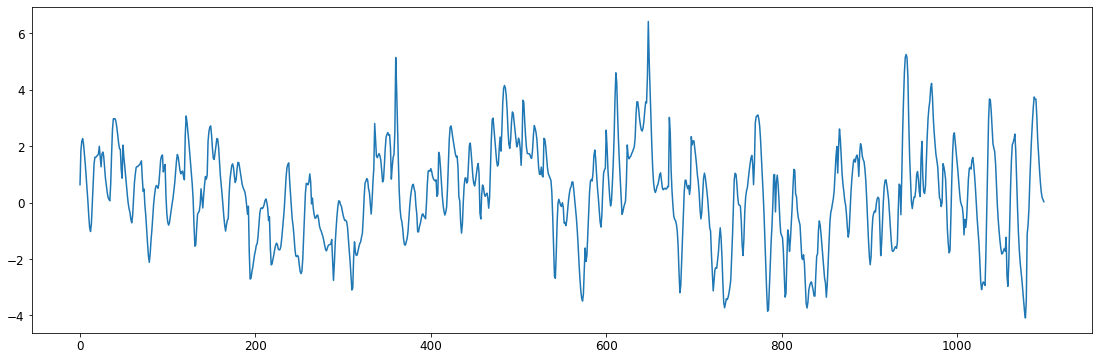

In [68]:
# prints a range of residue samples
plt.figure(figsize=(19,6))
plt.plot(components.resid[20000:21100])

In [69]:
# we see that the samples from 0 to period 8760 are nan 
components.resid[0:8760]

array([nan, nan, nan, ..., nan, nan, nan])

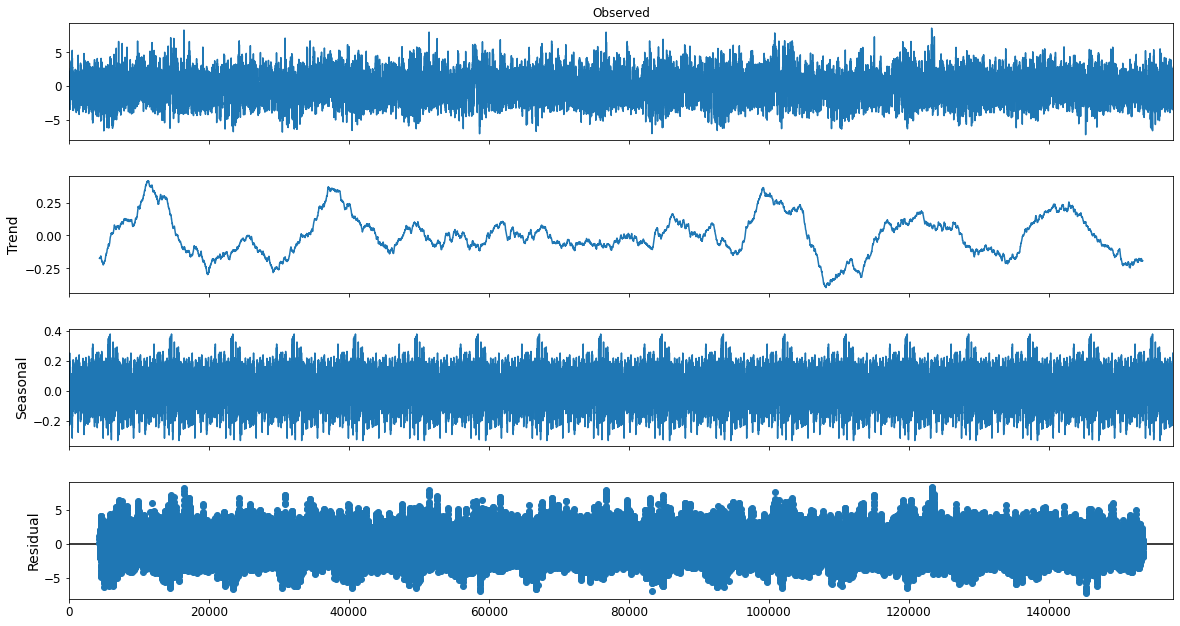

In [70]:
'''We test whether the residue or noise resulting from the decomposition of the 
time series has any kind of seasonality or trend that can be used as input for the neural networks.''' 

components_res = seasonal_decompose(components.resid[8760:], model='additive', period=8760)
fig = components_res.plot()
fig.set_size_inches((19,10))

In [71]:
# Variance of residual component
components.resid[8760:].var()

3.080074281000177

In [72]:
# Standar desviation
components.resid[8760:].std()

1.7550140401148298

In [73]:
# Mean
components.resid[8760:].mean()

-0.010253732614216323

After decomposing the noise, it can be seen that there are no representative trend or seasonality values, confirming that the first decomposition was correct. An important point to note at this stage is that noise represents an unpredictable variable, which means that any type of forecasting model must have a minimum achievable limit.

# Neural Networks applied to wind speed forcasting

**Note**: in this notebook, the blue dots represent targets, and red crosses represent predictions. 

Naive predictions (just predict the last observed value):

In [6]:
#Function to train models

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae',  patience=50,
                                                   mode='auto')

def train_model(model, name_model, name_monitor='val_mape', num_epoch=50):
    My_model_path = 'C:/Users/choco/OneDrive/DARIO Computador/UnB/Artigos/U-LSTM-NET/models_notebook/'+name_model+'.h5'
    checkpoint = ModelCheckpoint(My_model_path, monitor=name_monitor, verbose=1, save_best_only=True)
    
    model.compile(loss="mae", optimizer="adam", metrics=['mse','mae', 'mape', tfa.metrics.r_square.RSquare()])
    
    history = model.fit(X_train, Y_train, epochs=num_epoch, batch_size=128, validation_split = 0.2, shuffle=False,
                        callbacks=[checkpoint, early_stopping])
    
    return history

## Linear predictions using NN:

In [7]:
model_NN = keras.models.Sequential()
model_NN.add(Flatten(input_shape=[slide_timeStep, 1]))
model_NN.add(Dense(1))

In [8]:
model_NN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 65
Trainable params: 65
Non-trainable params: 0
_________________________________________________________________


In [9]:
name_model = 'model_NN'

history = train_model(model_NN, name_model)
model_NN = tf.keras.models.load_model('C:/Users/choco/OneDrive/DARIO Computador/UnB/Artigos/U-LSTM-NET/models_notebook/'+name_model+'.h5', compile=False)
model_NN.compile(loss="mae", optimizer="adam", metrics=['mse','mae', 'mape', tfa.metrics.r_square.RSquare()])
model_NN.evaluate(Inputs_test, targets_test)

Epoch 1/50
619/625 [============================>.] - ETA: 0s - loss: 1.7457 - mse: 6.3098 - mae: 1.7457 - mape: 57.8535 - r_square: -0.3209
Epoch 1: val_mape improved from inf to 34.95811, saving model to C:/Users/choco/OneDrive/DARIO Computador/UnB/Artigos/U-LSTM-NET/models_notebook\model_NN.h5
625/625 [==============================] - 5s 4ms/step - loss: 1.7389 - mse: 6.2678 - mae: 1.7389 - mape: 57.6128 - r_square: -0.3149 - val_loss: 0.9425 - val_mse: 1.4397 - val_mae: 0.9425 - val_mape: 34.9581 - val_r_square: 0.6908
Epoch 2/50
616/625 [============================>.] - ETA: 0s - loss: 0.7171 - mse: 0.8593 - mae: 0.7171 - mape: 24.8056 - r_square: 0.8202
Epoch 2: val_mape improved from 34.95811 to 21.47101, saving model to C:/Users/choco/OneDrive/DARIO Computador/UnB/Artigos/U-LSTM-NET/models_notebook\model_NN.h5
625/625 [==============================] - 2s 3ms/step - loss: 0.7151 - mse: 0.8545 - mae: 0.7151 - mape: 24.7307 - r_square: 0.8207 - val_loss: 0.5774 - val_mse: 0.558

[0.27208518981933594,
 0.18075187504291534,
 0.27208518981933594,
 9.8883056640625,
 0.961994469165802]

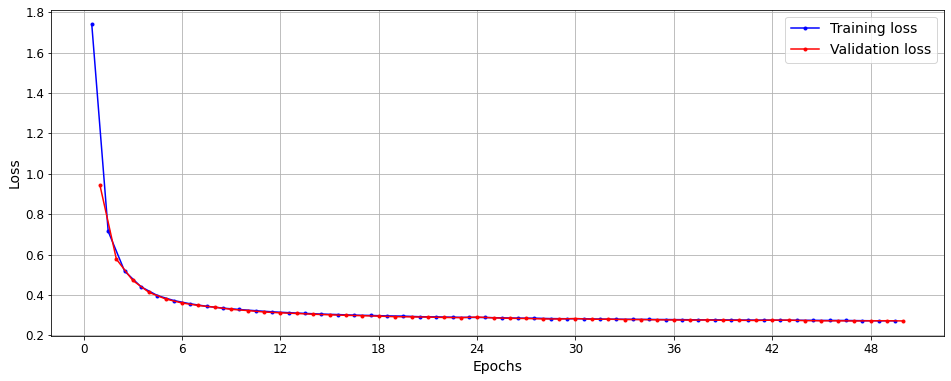

In [10]:
def plot_learning_curves(loss, val_loss):
    plt.figure(figsize=(16,6))
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    #plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [11]:
y_pred = model_NN.predict(X_test)

2082/2082 [==============================] - 2s 737us/step


In [40]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True, n_steps=64):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

In [41]:
X_test.shape #batch, time_steps, 1

(66598, 64, 1)

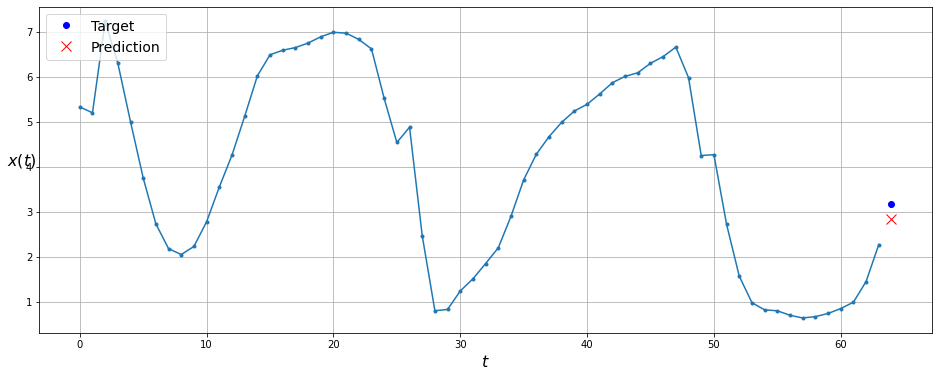

In [63]:
sample = 0
plt.figure(figsize=(16,6))
plot_series(X_test[sample, :, 0], Y_test[sample, 0], y_pred[sample, 0], n_steps=slide_timeStep)
plt.show()

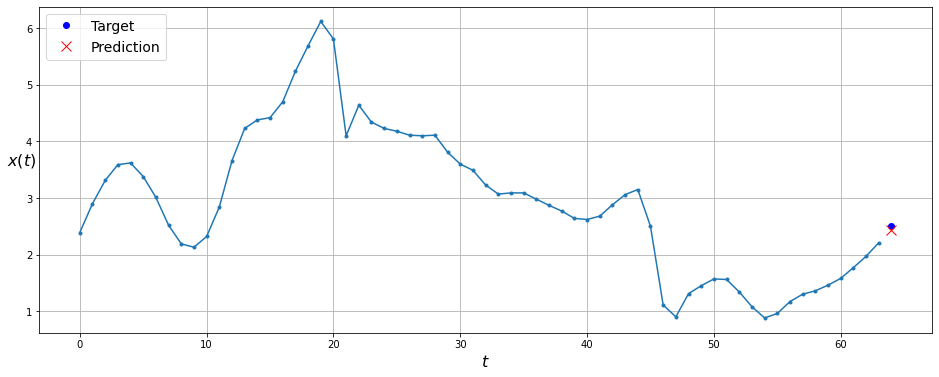

In [62]:
sample = 100
plt.figure(figsize=(16,6))
plot_series(X_test[sample, :, 0], Y_test[sample, 0], y_pred[sample, 0], n_steps=slide_timeStep)
plt.show()

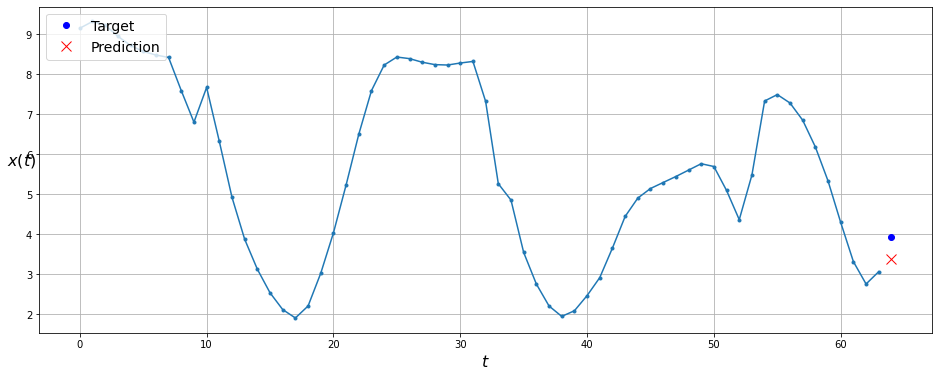

In [44]:
sample = 10000
plt.figure(figsize=(16,6))
plot_series(X_test[sample, :, 0], Y_test[sample, 0], y_pred[sample, 0], n_steps=slide_timeStep)
plt.show()

## Using a Deep GRU:

In [12]:
model_GRU = keras.models.Sequential()
model_GRU.add(GRU(32, return_sequences=True))
model_GRU.add(GRU(16, return_sequences=True))
model_GRU.add(GRU(1, return_sequences=True))
model_GRU.add(Flatten())
model_GRU.add(Dense(32))
model_GRU.add(Dense(16))
model_GRU.add(Dense(1))

name_model = 'model_GRU_01'

history = train_model(model_GRU, name_model)
model_GRU = tf.keras.models.load_model('C:/Users/choco/OneDrive/DARIO Computador/UnB/Artigos/U-LSTM-NET/models_notebook/'+name_model+'.h5', compile=False)
model_GRU.compile(loss="mae", optimizer="adam", metrics=['mse','mae', 'mape', tfa.metrics.r_square.RSquare()])
model_GRU.evaluate(Inputs_test, targets_test)

Epoch 1/50
623/625 [============================>.] - ETA: 0s - loss: 1.5776 - mse: 3.9446 - mae: 1.5776 - mape: 60.9268 - r_square: 0.1731
Epoch 1: val_mape improved from inf to 21.09720, saving model to C:/Users/choco/OneDrive/DARIO Computador/UnB/Artigos/U-LSTM-NET/models_notebook\model_GRU_01.h5
625/625 [==============================] - 21s 24ms/step - loss: 1.5755 - mse: 3.9374 - mae: 1.5755 - mape: 60.8456 - r_square: 0.1740 - val_loss: 0.6449 - val_mse: 0.7051 - val_mae: 0.6449 - val_mape: 21.0972 - val_r_square: 0.8486
Epoch 2/50
625/625 [==============================] - ETA: 0s - loss: 0.4130 - mse: 0.3378 - mae: 0.4130 - mape: 12.8423 - r_square: 0.9291
Epoch 2: val_mape improved from 21.09720 to 9.32367, saving model to C:/Users/choco/OneDrive/DARIO Computador/UnB/Artigos/U-LSTM-NET/models_notebook\model_GRU_01.h5
625/625 [==============================] - 14s 23ms/step - loss: 0.4130 - mse: 0.3378 - mae: 0.4130 - mape: 12.8423 - r_square: 0.9291 - val_loss: 0.3035 - val_m

[0.22250846028327942,
 0.12951044738292694,
 0.22250846028327942,
 8.272316932678223,
 0.9727686643600464]

In [13]:
model_GRU.summary(expand_nested=True, show_trainable=True)

Model: "sequential_1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 gru (GRU)                   (None, 64, 32)            3360      Y          
                                                                            
 gru_1 (GRU)                 (None, 64, 16)            2400      Y          
                                                                            
 gru_2 (GRU)                 (None, 64, 1)             57        Y          
                                                                            
 flatten_1 (Flatten)         (None, 64)                0         Y          
                                                                            
 dense_1 (Dense)             (None, 32)                2080      Y          
                                                                            
 dense_2 (Dense)             (None, 16)               

<Figure size 1152x432 with 0 Axes>

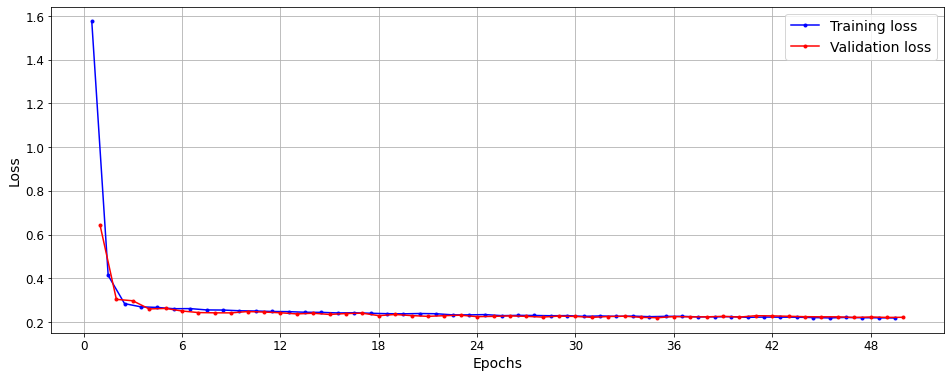

In [14]:
plt.figure(figsize=(16,6))
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [64]:
y_pred_GRU = model_GRU.predict(X_test)
model_GRU.evaluate(X_test, Y_test)

2082/2082 [==============================] - 26s 12ms/step - loss: 0.2308 - mse: 0.1360 - mae: 0.2308 - mape: 8.2353 - r_square: 0.9714


[0.23080070316791534,
 0.13599348068237305,
 0.23080070316791534,
 8.235326766967773,
 0.971405565738678]

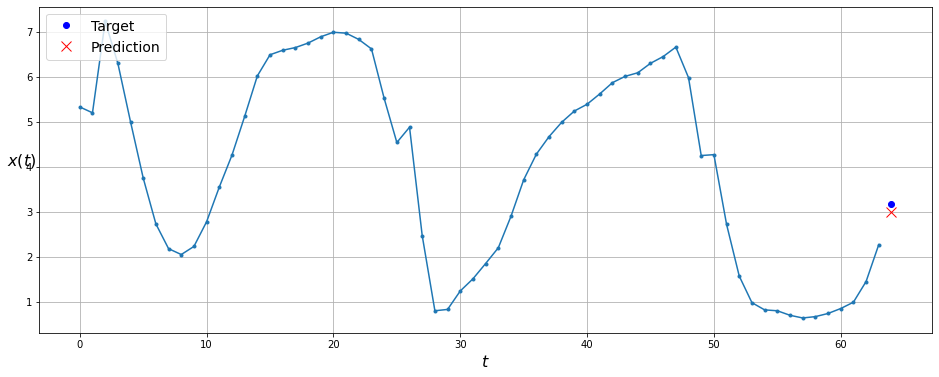

In [65]:
sample = 0
plt.figure(figsize=(16,6))
plot_series(X_test[sample, :, 0], Y_test[sample, 0], y_pred_GRU[sample, 0], n_steps=slide_timeStep)
plt.show()

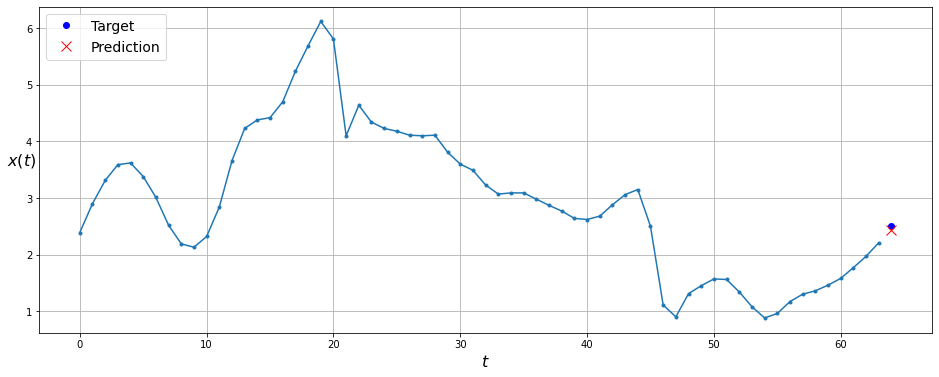

In [66]:
sample = 100
plt.figure(figsize=(16,6))
plot_series(X_test[sample, :, 0], Y_test[sample, 0], y_pred_GRU[sample, 0], n_steps=slide_timeStep)
plt.show()

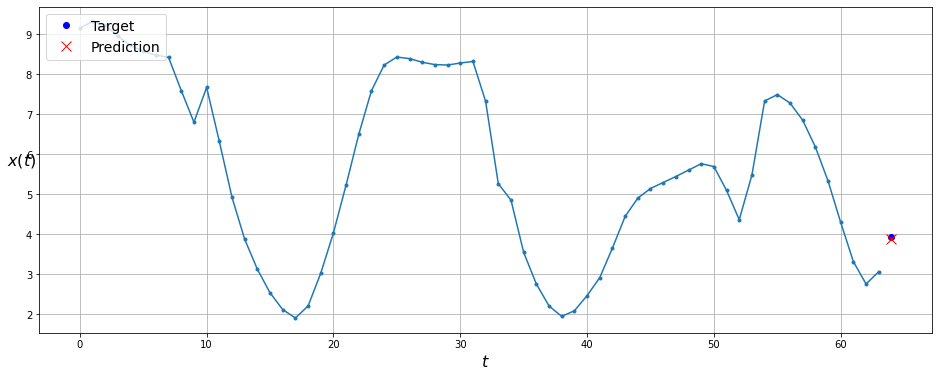

In [67]:
sample = 10000
plt.figure(figsize=(16,6))
plot_series(X_test[sample, :, 0], Y_test[sample, 0], y_pred_GRU[sample, 0], n_steps=slide_timeStep)
plt.show()

## Using a Deep LSTM:

In [73]:
model_LSTM = keras.models.Sequential()
model_LSTM.add(LSTM(32, return_sequences=True))
model_LSTM.add(LSTM(16, return_sequences=True))
model_LSTM.add(LSTM(1, return_sequences=True))
model_LSTM.add(Flatten())
model_LSTM.add(Dense(32))
model_LSTM.add(Dense(16))
model_LSTM.add(Dense(1))

name_model = 'model_LSTM_01'

history = train_model(model_LSTM, name_model)
model_LSTM = tf.keras.models.load_model('C:/Users/choco/OneDrive/DARIO Computador/UnB/Artigos/U-LSTM-NET/models_notebook/'+name_model+'.h5', compile=False)
model_LSTM.compile(loss="mae", optimizer="adam", metrics=['mse','mae', 'mape', tfa.metrics.r_square.RSquare()])
model_LSTM.evaluate(Inputs_test, targets_test)

logs\model_LSTM_01\20241211-180246
Epoch 1/50
311/313 [============================>.] - ETA: 0s - loss: 1.9188 - mse: 5.5753 - mae: 1.9188 - mape: 71.8070 - r_square: -0.1688
Epoch 1: val_mape improved from inf to 62.39658, saving model to C:/Users/choco/OneDrive/DARIO Computador/UnB/Artigos/U-LSTM-NET/models_notebook\model_LSTM_01.h5
313/313 [==============================] - 12s 26ms/step - loss: 1.9172 - mse: 5.5672 - mae: 1.9172 - mape: 71.6995 - r_square: -0.1679 - val_loss: 1.7163 - val_mse: 4.5491 - val_mae: 1.7163 - val_mape: 62.3966 - val_r_square: 0.0232
Epoch 2/50
311/313 [============================>.] - ETA: 0s - loss: 1.5582 - mse: 3.7202 - mae: 1.5582 - mape: 61.8835 - r_square: 0.2201
Epoch 2: val_mape improved from 62.39658 to 50.94462, saving model to C:/Users/choco/OneDrive/DARIO Computador/UnB/Artigos/U-LSTM-NET/models_notebook\model_LSTM_01.h5
313/313 [==============================] - 7s 24ms/step - loss: 1.5570 - mse: 3.7155 - mae: 1.5570 - mape: 61.7839 - r_sq

[0.22228382527828217,
 0.13180018961429596,
 0.22228382527828217,
 8.19516658782959,
 0.9722872376441956]

In [81]:
model_LSTM.summary(expand_nested=True, show_trainable=True)

Model: "sequential_5"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 lstm_2 (LSTM)               (None, 64, 32)            4352      Y          
                                                                            
 lstm_3 (LSTM)               (None, 64, 16)            3136      Y          
                                                                            
 lstm_4 (LSTM)               (None, 64, 1)             72        Y          
                                                                            
 flatten_3 (Flatten)         (None, 64)                0         Y          
                                                                            
 dense_10 (Dense)            (None, 32)                2080      Y          
                                                                            
 dense_11 (Dense)            (None, 16)               

In [76]:
y_pred_LSTM = model_LSTM.predict(X_test)
model_LSTM.evaluate(X_test, Y_test)

2082/2082 [==============================] - 21s 10ms/step - loss: 0.2264 - mse: 0.1333 - mae: 0.2264 - mape: 8.4300 - r_square: 0.9720


[0.22640137374401093,
 0.133295476436615,
 0.22640137374401093,
 8.430020332336426,
 0.9719728231430054]

<Figure size 1152x432 with 0 Axes>

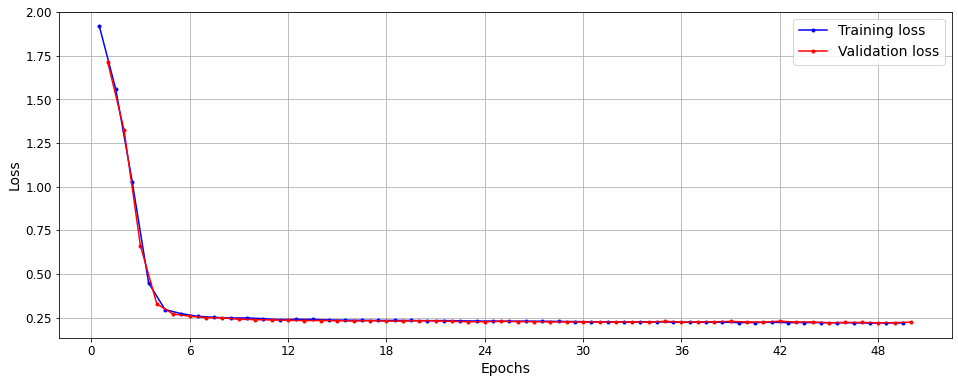

In [77]:
plt.figure(figsize=(16,6))
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

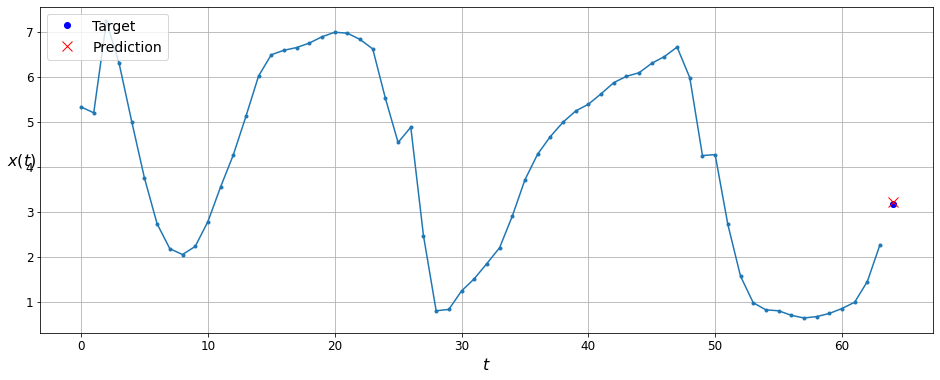

In [78]:
sample = 0
plt.figure(figsize=(16,6))
plot_series(X_test[sample, :, 0], Y_test[sample, 0], y_pred_LSTM[sample, 0], n_steps=slide_timeStep)
plt.show()

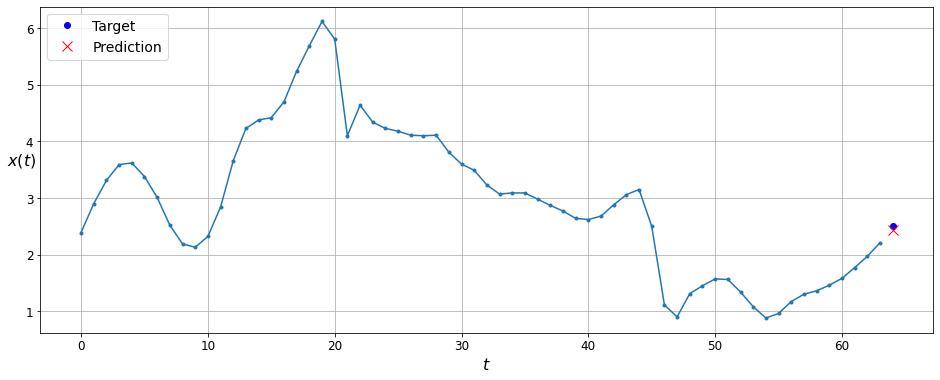

In [79]:
sample = 100
plt.figure(figsize=(16,6))
plot_series(X_test[sample, :, 0], Y_test[sample, 0], y_pred_GRU[sample, 0], n_steps=slide_timeStep)
plt.show()

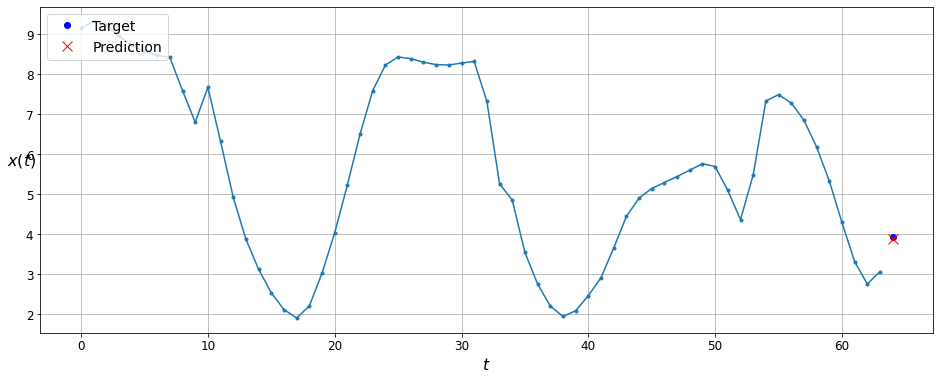

In [80]:
sample = 10000
plt.figure(figsize=(16,6))
plot_series(X_test[sample, :, 0], Y_test[sample, 0], y_pred_GRU[sample, 0], n_steps=slide_timeStep)
plt.show()

## Using Deep GRU with last layer return only the last output (return_sequences=False):

In [98]:
model_GRU_02 = keras.models.Sequential()
model_GRU_02.add(GRU(32, return_sequences=True))
model_GRU_02.add(GRU(16, return_sequences=True))
model_GRU_02.add(GRU(8, return_sequences=False))
model_GRU_02.add(Dense(1))

name_model = 'model_GRU_02'

history = train_model(model_GRU_02, name_model)
model_GRU_02 = tf.keras.models.load_model('C:/Users/choco/OneDrive/DARIO Computador/UnB/Artigos/U-LSTM-NET/models_notebook/'+name_model+'.h5', compile=False)
model_GRU_02.compile(loss="mae", optimizer="adam", metrics=['mse','mae', 'mape', tfa.metrics.r_square.RSquare()])
model_GRU_02.evaluate(Inputs_test, targets_test)

logs\model_GRU_02\20241211-183309
Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 1.6984 - mse: 5.5516 - mae: 1.6984 - mape: 39.7294 - r_square: -0.1646
Epoch 1: val_mape improved from inf to 16.67238, saving model to C:/Users/choco/OneDrive/DARIO Computador/UnB/Artigos/U-LSTM-NET/models_notebook\model_GRU_02.h5
313/313 [==============================] - 11s 25ms/step - loss: 1.6984 - mse: 5.5516 - mae: 1.6984 - mape: 39.7294 - r_square: -0.1646 - val_loss: 0.8025 - val_mse: 1.7187 - val_mae: 0.8025 - val_mape: 16.6724 - val_r_square: 0.6309
Epoch 2/50
312/313 [============================>.] - ETA: 0s - loss: 0.6120 - mse: 1.0931 - mae: 0.6120 - mape: 12.7521 - r_square: 0.7707
Epoch 2: val_mape improved from 16.67238 to 10.74438, saving model to C:/Users/choco/OneDrive/DARIO Computador/UnB/Artigos/U-LSTM-NET/models_notebook\model_GRU_02.h5
313/313 [==============================] - 7s 23ms/step - loss: 0.6118 - mse: 1.0926 - mae: 0.6118 - mape: 12.7499 - r_squar

[0.23125174641609192,
 0.14700531959533691,
 0.23125174641609192,
 8.209146499633789,
 0.9690901637077332]

In [101]:
model_GRU_02.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_30 (GRU)                (None, 64, 32)            3360      
                                                                 
 gru_31 (GRU)                (None, 64, 16)            2400      
                                                                 
 gru_32 (GRU)                (None, 8)                 624       
                                                                 
 dense_19 (Dense)            (None, 1)                 9         
                                                                 
Total params: 6,393
Trainable params: 6,393
Non-trainable params: 0
_________________________________________________________________


In [100]:
y_pred_GRU_02 = model_GRU_02.predict(X_test)
model_GRU_02.evaluate(X_test, Y_test)

2082/2082 [==============================] - 25s 11ms/step - loss: 0.2313 - mse: 0.1470 - mae: 0.2313 - mape: 8.2091 - r_square: 0.9691


[0.23125174641609192,
 0.14700531959533691,
 0.23125174641609192,
 8.209146499633789,
 0.9690901637077332]

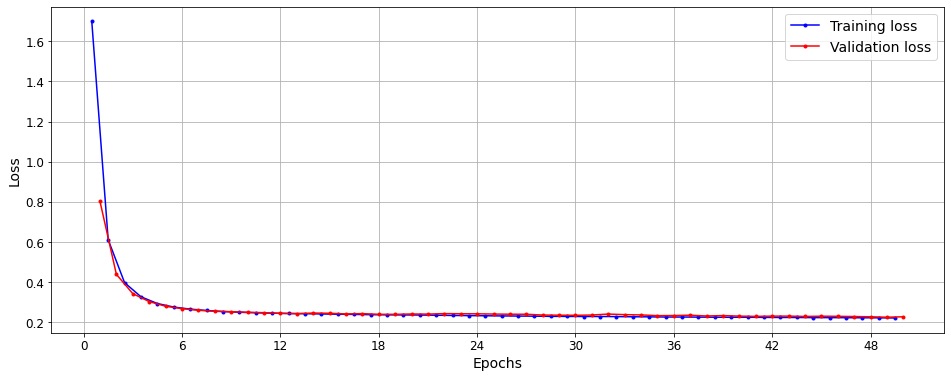

In [102]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

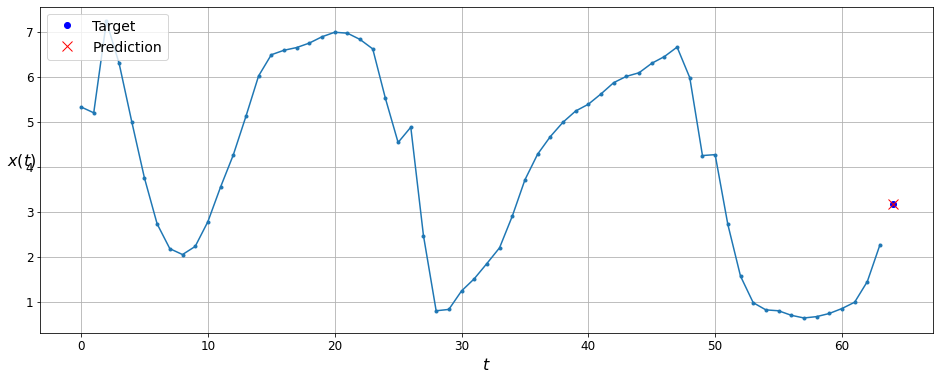

In [105]:
sample = 0
plt.figure(figsize=(16,6))
plot_series(X_test[sample, :, 0], Y_test[sample, 0], y_pred_GRU_02[sample, 0], n_steps=slide_timeStep)
plt.show()

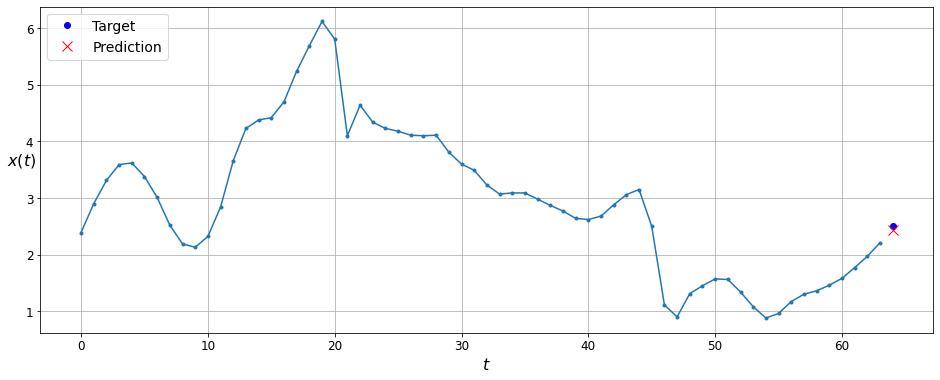

In [104]:
sample = 100
plt.figure(figsize=(16,6))
plot_series(X_test[sample, :, 0], Y_test[sample, 0], y_pred_GRU_02[sample, 0], n_steps=slide_timeStep)
plt.show()

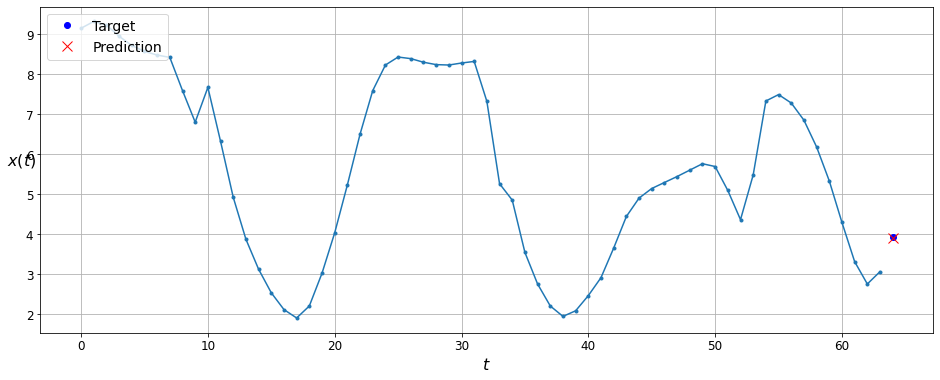

In [103]:
sample = 10000
plt.figure(figsize=(16,6))
plot_series(X_test[sample, :, 0], Y_test[sample, 0], y_pred_GRU_02[sample, 0], n_steps=slide_timeStep)
plt.show()

# In this section we will use a time window of 128 samples

## Dataset pre-procesing

In [340]:
samples = len(ws_meanxhora)
slide_timeStep = 128
num_features = 1
 
data = np.array(ws_meanxhora[["Wind Speed"]])#, 'Wind Dir Sin', 'Wind Dir Cos']])
#Data_set completo
data_set = np.array([data[i:i+slide_timeStep] for i in range(samples-slide_timeStep)])
#Targets completo  
target_set = data[slide_timeStep:][:, 0]

Inputs_train, Inputs_test, targets_train, targets_test =\
                        train_test_split(data_set, target_set, test_size=0.4, 
                        shuffle=False, random_state=None)
                        
X_train, Y_train = Inputs_train, targets_train.reshape(-1,1)   
X_test, Y_test = Inputs_test, targets_test.reshape(-1,1) 

## Using Deep GRU

In [129]:
model_GRU_04 = keras.models.Sequential()
model_GRU_04.add(GRU(64, return_sequences=True))
model_GRU_04.add(GRU(32, return_sequences=True))
model_GRU_04.add(GRU(16, return_sequences=True))
model_GRU_04.add(Flatten())
model_GRU_04.add(Dense(16))
model_GRU_04.add(Dense(8))
model_GRU_04.add(Dense(1))

name_model = 'model_LSTM_02'

history = train_model(model_GRU_04, name_model)
model_GRU_04 = tf.keras.models.load_model('C:/Users/choco/OneDrive/DARIO Computador/UnB/Artigos/U-LSTM-NET/models_notebook/'+name_model+'.h5', compile=False)
model_GRU_04.compile(loss="mae", optimizer="adam", metrics=['mse','mae', 'mape', tfa.metrics.r_square.RSquare()])
model_GRU_04.evaluate(Inputs_test, targets_test)

logs\model_LSTM_02\20241211-222623
Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 0.9087 - mse: 1.6641 - mae: 0.9087 - mape: 34.3309 - r_square: 0.6511
Epoch 1: val_mape improved from inf to 13.00630, saving model to C:/Users/choco/OneDrive/DARIO Computador/UnB/Artigos/U-LSTM-NET/models_notebook\model_LSTM_02.h5
313/313 [==============================] - 16s 40ms/step - loss: 0.9087 - mse: 1.6641 - mae: 0.9087 - mape: 34.3309 - r_square: 0.6511 - val_loss: 0.3634 - val_mse: 0.2482 - val_mae: 0.3634 - val_mape: 13.0063 - val_r_square: 0.9467
Epoch 2/50
312/313 [============================>.] - ETA: 0s - loss: 0.3954 - mse: 0.2906 - mae: 0.3954 - mape: 12.8748 - r_square: 0.9391
Epoch 2: val_mape improved from 13.00630 to 10.82435, saving model to C:/Users/choco/OneDrive/DARIO Computador/UnB/Artigos/U-LSTM-NET/models_notebook\model_LSTM_02.h5
313/313 [==============================] - 13s 40ms/step - loss: 0.3954 - mse: 0.2905 - mae: 0.3954 - mape: 12.8738 - r_squ

[0.23048436641693115,
 0.1262565702199936,
 0.23048436641693115,
 8.214776992797852,
 0.9734562039375305]

In [130]:
model_GRU_04.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_36 (GRU)                (None, 128, 64)           12864     
                                                                 
 gru_37 (GRU)                (None, 128, 32)           9408      
                                                                 
 gru_38 (GRU)                (None, 128, 16)           2400      
                                                                 
 flatten_7 (Flatten)         (None, 2048)              0         
                                                                 
 dense_27 (Dense)            (None, 16)                32784     
                                                                 
 dense_28 (Dense)            (None, 8)                 136       
                                                                 
 dense_29 (Dense)            (None, 1)               

In [131]:
y_pred_GRU_04 = model_GRU_04.predict(X_test)
model_GRU_04.evaluate(X_test, Y_test)

2081/2081 [==============================] - 37s 17ms/step - loss: 0.2305 - mse: 0.1263 - mae: 0.2305 - mape: 8.2148 - r_square: 0.9735


[0.23048436641693115,
 0.1262565702199936,
 0.23048436641693115,
 8.214776992797852,
 0.9734562039375305]

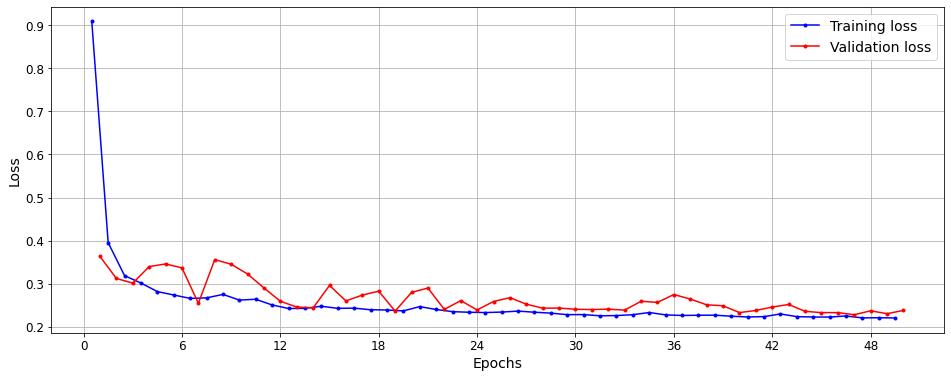

In [132]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

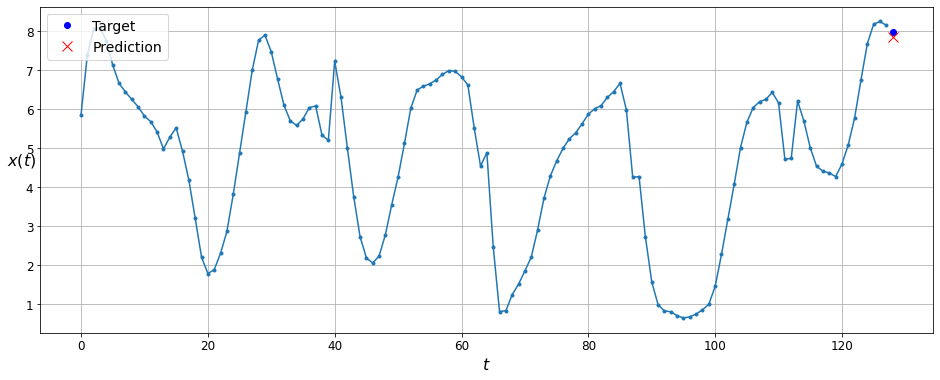

In [133]:
sample = 0
plt.figure(figsize=(16,6))
plot_series(X_test[sample, :, 0], Y_test[sample, 0], y_pred_GRU_04[sample, 0], n_steps=slide_timeStep)
plt.show()

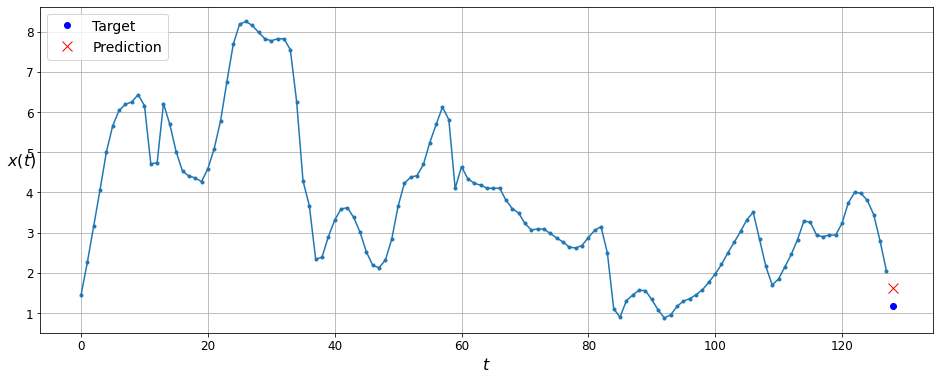

In [134]:
sample = 100
plt.figure(figsize=(16,6))
plot_series(X_test[sample, :, 0], Y_test[sample, 0], y_pred_GRU_04[sample, 0], n_steps=slide_timeStep)
plt.show()

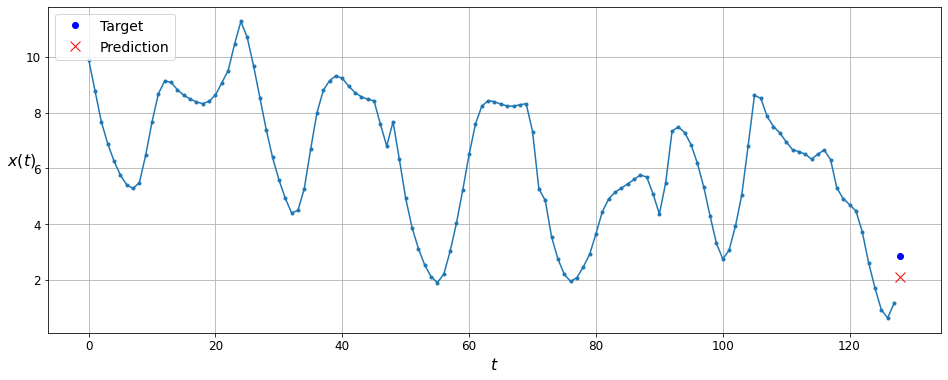

In [135]:
sample = 10000
plt.figure(figsize=(16,6))
plot_series(X_test[sample, :, 0], Y_test[sample, 0], y_pred_GRU_04[sample, 0], n_steps=slide_timeStep)
plt.show()

## Using Deep LSTM

In [119]:
model_LSTM_02 = keras.models.Sequential()
model_LSTM_02.add(LSTM(64, return_sequences=True))
model_LSTM_02.add(LSTM(32, return_sequences=True))
model_LSTM_02.add(LSTM(16, return_sequences=True))
model_LSTM_02.add(Flatten())
model_LSTM_02.add(Dense(16))
model_LSTM_02.add(Dense(8))
model_LSTM_02.add(Dense(1))

#%tensorboard --logdir logs
name_model = 'model_LSTM_02'

history = train_model(model_LSTM_02, name_model)
model_LSTM_02 = tf.keras.models.load_model('C:/Users/choco/OneDrive/DARIO Computador/UnB/Artigos/U-LSTM-NET/models_notebook/'+name_model+'.h5', compile=False)
model_LSTM_02.compile(loss="mae", optimizer="adam", metrics=['mse','mae', 'mape', tfa.metrics.r_square.RSquare()])
model_LSTM_02.evaluate(Inputs_test, targets_test)

logs\model_LSTM_02\20241211-212312
Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 1.5237 - mse: 3.7087 - mae: 1.5237 - mape: 59.6563 - r_square: 0.2224
Epoch 1: val_mape improved from inf to 49.36648, saving model to C:/Users/choco/OneDrive/DARIO Computador/UnB/Artigos/U-LSTM-NET/models_notebook\model_LSTM_02.h5
313/313 [==============================] - 17s 43ms/step - loss: 1.5237 - mse: 3.7087 - mae: 1.5237 - mape: 59.6563 - r_square: 0.2224 - val_loss: 1.1667 - val_mse: 2.1932 - val_mae: 1.1667 - val_mape: 49.3665 - val_r_square: 0.5290
Epoch 2/50
313/313 [==============================] - ETA: 0s - loss: 0.7275 - mse: 0.9783 - mae: 0.7275 - mape: 27.8847 - r_square: 0.7949
Epoch 2: val_mape improved from 49.36648 to 16.29475, saving model to C:/Users/choco/OneDrive/DARIO Computador/UnB/Artigos/U-LSTM-NET/models_notebook\model_LSTM_02.h5
313/313 [==============================] - 13s 41ms/step - loss: 0.7275 - mse: 0.9783 - mae: 0.7275 - mape: 27.8847 - r_squ

[0.21805770695209503,
 0.12192938476800919,
 0.21805770695209503,
 7.863147258758545,
 0.9743659496307373]

In [121]:
model_LSTM_02.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 128, 64)           16896     
                                                                 
 lstm_9 (LSTM)               (None, 128, 32)           12416     
                                                                 
 lstm_10 (LSTM)              (None, 128, 16)           3136      
                                                                 
 flatten_6 (Flatten)         (None, 2048)              0         
                                                                 
 dense_24 (Dense)            (None, 16)                32784     
                                                                 
 dense_25 (Dense)            (None, 8)                 136       
                                                                 
 dense_26 (Dense)            (None, 1)               

In [122]:
y_pred_LSTM_02 = model_LSTM_02.predict(X_test)
model_LSTM_02.evaluate(X_test, Y_test)

2081/2081 [==============================] - 36s 17ms/step - loss: 0.2181 - mse: 0.1219 - mae: 0.2181 - mape: 7.8631 - r_square: 0.9744


[0.21805770695209503,
 0.12192938476800919,
 0.21805770695209503,
 7.863147258758545,
 0.9743659496307373]

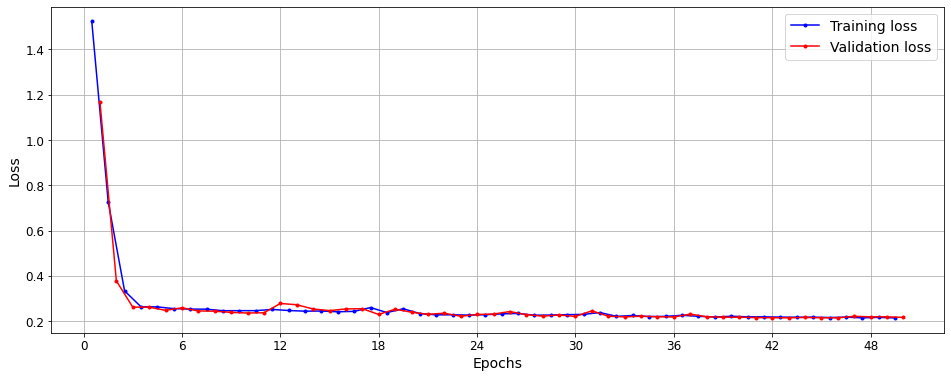

In [123]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

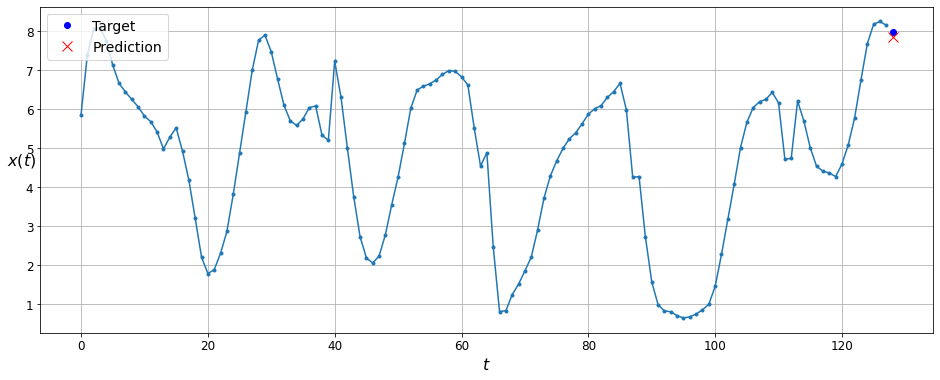

In [124]:
sample = 0
plt.figure(figsize=(16,6))
plot_series(X_test[sample, :, 0], Y_test[sample, 0], y_pred_LSTM_02[sample, 0], n_steps=slide_timeStep)
plt.show()

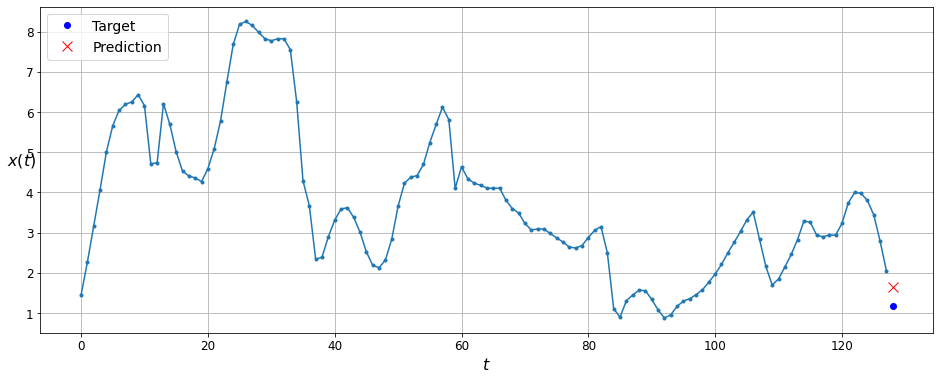

In [125]:
sample =100
plt.figure(figsize=(16,6))
plot_series(X_test[sample, :, 0], Y_test[sample, 0], y_pred_LSTM_02[sample, 0], n_steps=slide_timeStep)
plt.show()

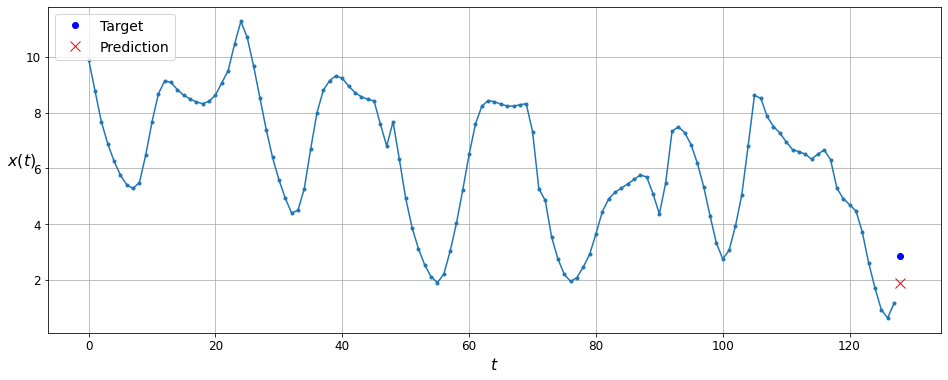

In [128]:
sample = 10000
plt.figure(figsize=(16,6))
plot_series(X_test[sample, :, 0], Y_test[sample, 0], y_pred_LSTM_02[sample, 0], n_steps=slide_timeStep)
plt.show()

## Using Deep GRU with last layer return only the last output (return_sequences=False)

In [107]:
model_GRU_03 = keras.models.Sequential()
model_GRU_03.add(GRU(64, return_sequences=True))
model_GRU_03.add(GRU(32, return_sequences=True))
model_GRU_03.add(GRU(16, return_sequences=False))
model_GRU_03.add(Dense(1))

name_model = 'model_GRU_03'

history = train_model(model_GRU_03, name_model)
model_GRU_03 = tf.keras.models.load_model('C:/Users/choco/OneDrive/DARIO Computador/UnB/Artigos/U-LSTM-NET/models_notebook/'+name_model+'.h5', compile=False)
model_GRU_03.compile(loss="mae", optimizer="adam", metrics=['mse','mae', 'mape', tfa.metrics.r_square.RSquare()])
model_GRU_03.evaluate(Inputs_test, targets_test)

logs\model_GRU_03\20241211-210201
Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 0.9875 - mse: 2.3808 - mae: 0.9875 - mape: 25.7238 - r_square: 0.5008
Epoch 1: val_mape improved from inf to 10.75303, saving model to C:/Users/choco/OneDrive/DARIO Computador/UnB/Artigos/U-LSTM-NET/models_notebook\model_GRU_03.h5
313/313 [==============================] - 17s 41ms/step - loss: 0.9875 - mse: 2.3808 - mae: 0.9875 - mape: 25.7238 - r_square: 0.5008 - val_loss: 0.3912 - val_mse: 0.4383 - val_mae: 0.3912 - val_mape: 10.7530 - val_r_square: 0.9059
Epoch 2/50
312/313 [============================>.] - ETA: 0s - loss: 0.3412 - mse: 0.3174 - mae: 0.3412 - mape: 9.4556 - r_square: 0.9335
Epoch 2: val_mape improved from 10.75303 to 9.88060, saving model to C:/Users/choco/OneDrive/DARIO Computador/UnB/Artigos/U-LSTM-NET/models_notebook\model_GRU_03.h5
313/313 [==============================] - 12s 38ms/step - loss: 0.3411 - mse: 0.3173 - mae: 0.3411 - mape: 9.4551 - r_square: 0

[0.22521235048770905,
 0.13857151567935944,
 0.22521235048770905,
 7.916667461395264,
 0.9708671569824219]

In [109]:
model_GRU_03.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_33 (GRU)                (None, 128, 64)           12864     
                                                                 
 gru_34 (GRU)                (None, 128, 32)           9408      
                                                                 
 gru_35 (GRU)                (None, 16)                2400      
                                                                 
 dense_20 (Dense)            (None, 1)                 17        
                                                                 
Total params: 24,689
Trainable params: 24,689
Non-trainable params: 0
_________________________________________________________________


In [110]:
y_pred_GRU_03 = model_GRU_03.predict(X_test)
model_GRU_03.evaluate(X_test, Y_test)

2081/2081 [==============================] - 37s 18ms/step - loss: 0.2252 - mse: 0.1386 - mae: 0.2252 - mape: 7.9167 - r_square: 0.9709


[0.22521235048770905,
 0.13857151567935944,
 0.22521235048770905,
 7.916667461395264,
 0.9708671569824219]

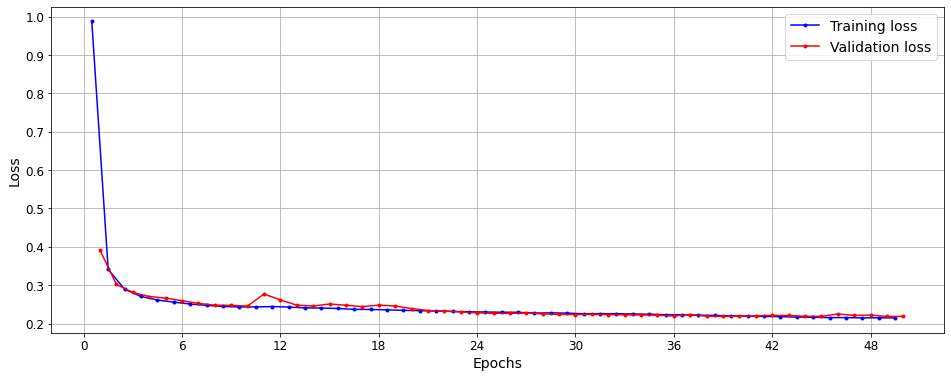

In [111]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

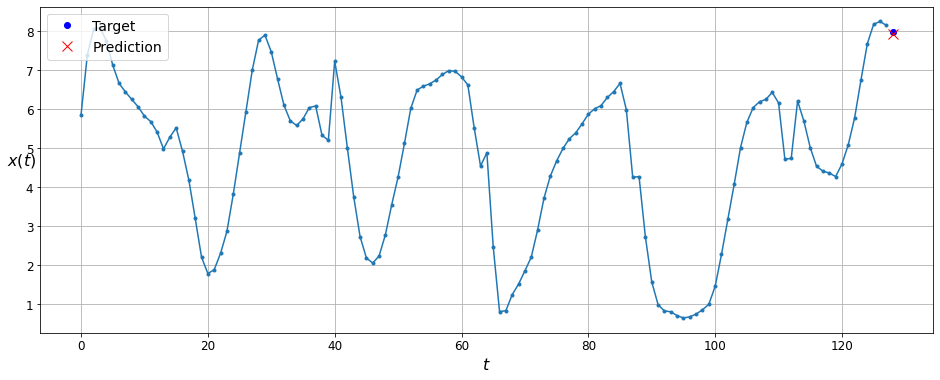

In [112]:
sample = 0
plt.figure(figsize=(16,6))
plot_series(X_test[sample, :, 0], Y_test[sample, 0], y_pred_GRU_03[sample, 0], n_steps=slide_timeStep)
plt.show()

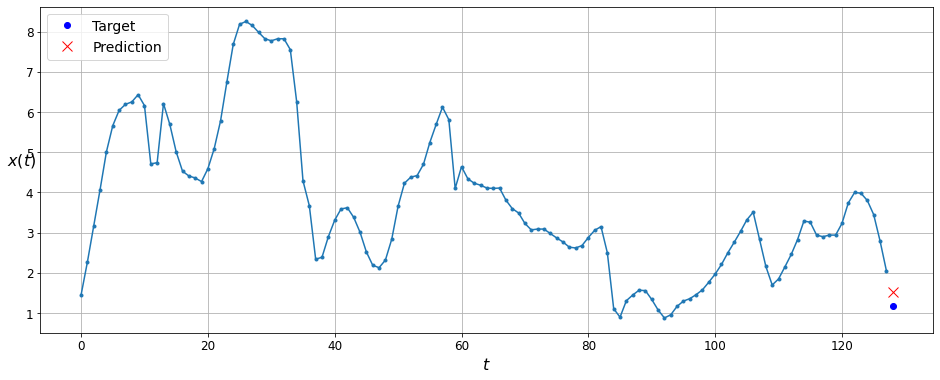

In [113]:
sample = 100
plt.figure(figsize=(16,6))
plot_series(X_test[sample, :, 0], Y_test[sample, 0], y_pred_GRU_03[sample, 0], n_steps=slide_timeStep)
plt.show()

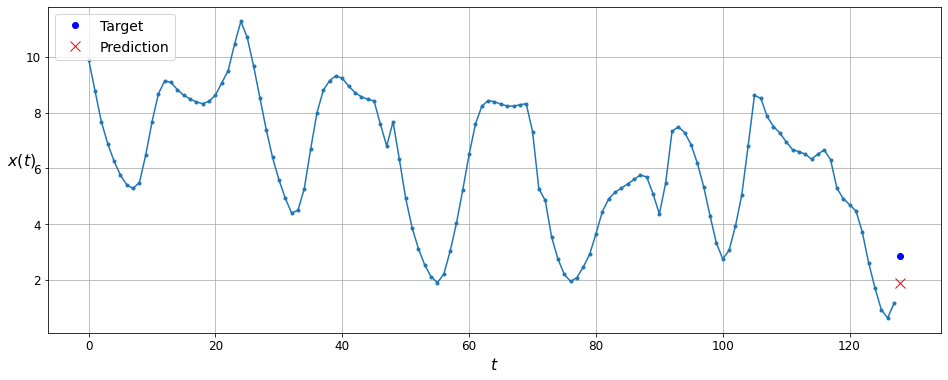

In [114]:
sample = 10000
plt.figure(figsize=(16,6))
plot_series(X_test[sample, :, 0], Y_test[sample, 0], y_pred_GRU_03[sample, 0], n_steps=slide_timeStep)
plt.show()

## Convolutional - LSTM - Dense Model:

In [182]:
def MODEL():
    input_shape = (slide_timeStep, num_features)
    Inputs = Input(input_shape, name='Input')
    Conv_In0 = Conv1D(4, kernel_size=2, activation="relu", padding='same',
                    dilation_rate=1)(Inputs)
    Conv_In1 = Conv1D(4, kernel_size=12, activation="relu", padding='same',
                    dilation_rate=1)(Inputs)
    Conv_In2 = Conv1D(4, kernel_size=24, activation="relu", padding='same',
                    dilation_rate=1)(Inputs)
    #Conv_In0 = BatchNormalization()(Conv_In0)
    #Conv_In1 = BatchNormalization()(Conv_In1)
    #Conv_In2 = BatchNormalization()(Conv_In2)
    #Inputs_norm = BatchNormalization()(Inputs)
    
    lstm_a = LSTM(units=32, return_sequences=True)(Inputs)
    lstm_b = LSTM(units=32, return_sequences=True)(Conv_In0)
    lstm_c = LSTM(units=32, return_sequences=True)(Conv_In1)
    lstm_d = LSTM(units=32, return_sequences=True)(Conv_In2)
    #lstm_a = BatchNormalization()(lstm_a)
    #lstm_b = BatchNormalization()(lstm_b)
    #lstm_c = BatchNormalization()(lstm_c)
    #lstm_d = BatchNormalization()(lstm_d)
    
    lstm_a = LSTM(units=16, return_sequences=True)(lstm_a)
    lstm_b = LSTM(units=16, return_sequences=True)(lstm_b)
    lstm_c = LSTM(units=16, return_sequences=True)(lstm_c)
    lstm_d = LSTM(units=16, return_sequences=True)(lstm_d)
    #lstm_a = BatchNormalization()(lstm_a)
    #lstm_b = BatchNormalization()(lstm_b)
    #lstm_c = BatchNormalization()(lstm_c)
    #lstm_d = BatchNormalization()(lstm_d)

    lstm_a = LSTM(units=4, return_sequences=True)(lstm_a)
    lstm_b = LSTM(units=4, return_sequences=True)(lstm_b)
    lstm_c = LSTM(units=4, return_sequences=True)(lstm_c)
    lstm_d = LSTM(units=4, return_sequences=True)(lstm_d)

    #Conv_a = Conv1D(1, kernel_size=1, activation="relu")(lstm_a)
    #Conv_b = Conv1D(1, kernel_size=1, activation="relu")(lstm_b)
    #Conv_c = Conv1D(1, kernel_size=1, activation="relu")(lstm_c)
    #Conv_d = Conv1D(1, kernel_size=1, activation="relu")(lstm_d)

    add = Add()([lstm_a, lstm_b, lstm_c, lstm_d])
    
    dense = Dense(32)(Flatten()(add))

    dense_a = Dense(1)(dense)
    dense_b = Dense(1)(dense)
    dense_c = Dense(1)(dense)
    dense_d = Dense(1)(dense)

    output = Average()([dense_a,
                        dense_b,
                        dense_c,
                        dense_d])
    
    return Model(Inputs, output)


In [183]:
model = MODEL()

In [185]:
name_model = 'model_Conv_LSTM_01'

history = train_model(model, name_model)
model_Conv_LSTM_01 = tf.keras.models.load_model('C:/Users/choco/OneDrive/DARIO Computador/UnB/Artigos/U-LSTM-NET/models_notebook/'+name_model+'.h5', compile=False)
model_Conv_LSTM_01.compile(loss="mae", optimizer="adam", metrics=['mse','mae', 'mape', tfa.metrics.r_square.RSquare()])
model_Conv_LSTM_01.evaluate(Inputs_test, targets_test)

logs\model_Conv_LSTM_01\20241212-111343
Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 0.2065 - mse: 0.1088 - mae: 0.2065 - mape: 7.1044 - r_square: 0.9772
Epoch 1: val_mape improved from inf to 7.45821, saving model to C:/Users/choco/OneDrive/DARIO Computador/UnB/Artigos/U-LSTM-NET/models_notebook\model_Conv_LSTM_01.h5
313/313 [==============================] - 79s 211ms/step - loss: 0.2065 - mse: 0.1088 - mae: 0.2065 - mape: 7.1044 - r_square: 0.9772 - val_loss: 0.2061 - val_mse: 0.1092 - val_mae: 0.2061 - val_mape: 7.4582 - val_r_square: 0.9765
Epoch 2/50
313/313 [==============================] - ETA: 0s - loss: 0.2048 - mse: 0.1073 - mae: 0.2048 - mape: 7.0638 - r_square: 0.9775
Epoch 2: val_mape improved from 7.45821 to 7.35638, saving model to C:/Users/choco/OneDrive/DARIO Computador/UnB/Artigos/U-LSTM-NET/models_notebook\model_Conv_LSTM_01.h5
313/313 [==============================] - 49s 156ms/step - loss: 0.2048 - mse: 0.1073 - mae: 0.2048 - mape: 7.063

[0.20706254243850708,
 0.1082068607211113,
 0.20706254243850708,
 7.574681758880615,
 0.9772509336471558]

In [187]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 128, 1)]     0           []                               
                                                                                                  
 conv1d_63 (Conv1D)             (None, 128, 4)       12          ['Input[0][0]']                  
                                                                                                  
 conv1d_64 (Conv1D)             (None, 128, 4)       52          ['Input[0][0]']                  
                                                                                                  
 conv1d_65 (Conv1D)             (None, 128, 4)       100         ['Input[0][0]']                  
                                                                                            

In [188]:
y_pred_Conv_LSTM_01 = model_Conv_LSTM_01.predict(X_test)
model_Conv_LSTM_01.evaluate(X_test, Y_test)

2081/2081 [==============================] - 115s 53ms/step - loss: 0.2071 - mse: 0.1082 - mae: 0.2071 - mape: 7.5747 - r_square: 0.9773


[0.20706254243850708,
 0.1082068607211113,
 0.20706254243850708,
 7.574681758880615,
 0.9772509336471558]

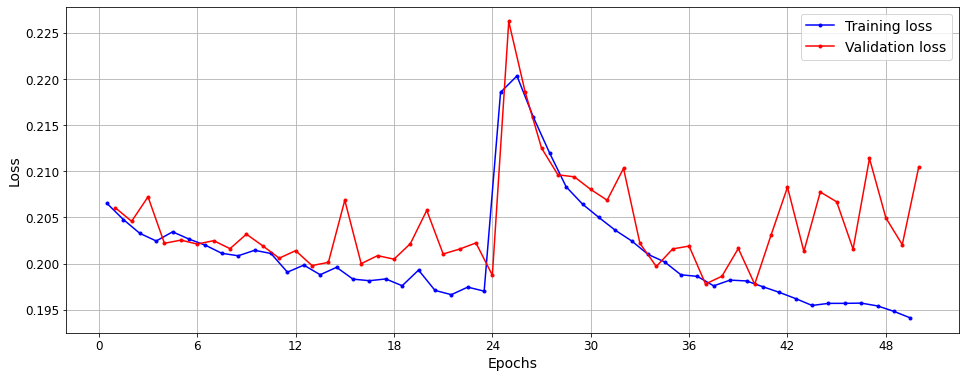

In [189]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

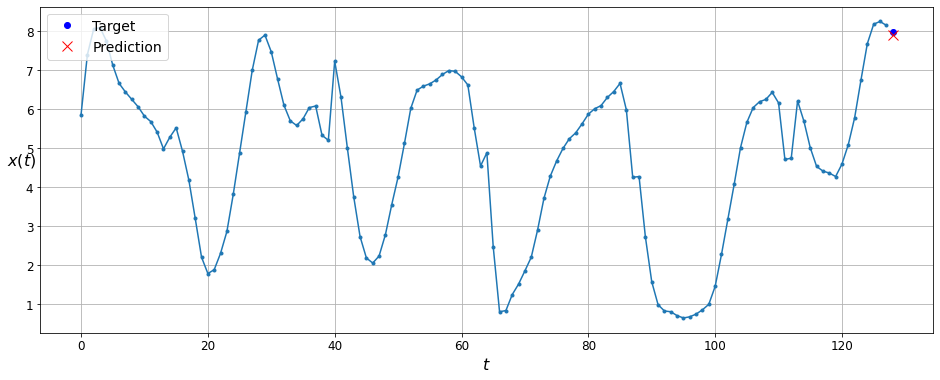

In [191]:
sample = 0
plt.figure(figsize=(16,6))
plot_series(X_test[sample, :, 0], Y_test[sample, 0], y_pred_Conv_LSTM_01[sample, 0], n_steps=slide_timeStep)
plt.show()

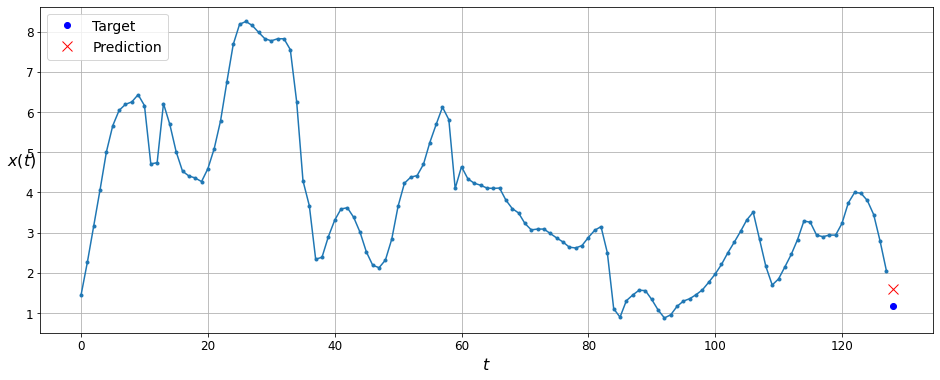

In [192]:
sample = 100
plt.figure(figsize=(16,6))
plot_series(X_test[sample, :, 0], Y_test[sample, 0], y_pred_Conv_LSTM_01[sample, 0], n_steps=slide_timeStep)
plt.show()

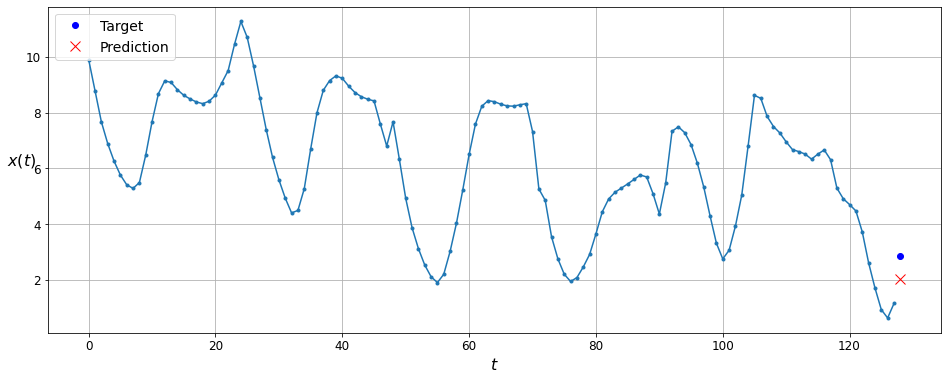

In [193]:
sample = 10000
plt.figure(figsize=(16,6))
plot_series(X_test[sample, :, 0], Y_test[sample, 0], y_pred_Conv_LSTM_01[sample, 0], n_steps=slide_timeStep)
plt.show()

## GRU - Convolutional Model:

In [170]:
def MODEL_GRU_Simple_128_Conv_encoder_32_16_1():
    input_shape = (slide_timeStep, num_features)
    Inputs = Input(input_shape, name='Input')
    
    gru = GRU(units=128, return_sequences=True)(Inputs)
    
    #gru = LayerNormalization()(gru)

    conv = Conv1D(32, kernel_size=1, activation="relu")(gru)
    conv = Conv1D(16, kernel_size=1, activation="relu")(conv)
    conv = Conv1D(1, kernel_size=1,  activation="relu")(conv)
    #conv = LayerNormalization()(conv)

    cropp_layer = Cropping1D(cropping=(slide_timeStep-1,0))(conv)
    output = Reshape((-1,))(cropp_layer)
    
    return Model(Inputs, output)

In [171]:
model = MODEL_GRU_Simple_128_Conv_encoder_32_16_1()

In [172]:
name_model = 'GRU_Simple_128_Conv_encoder_32_16_1'

history = train_model(model, name_model, num_epoch=100)
model_Conv_GRU_Simple_128_Conv_encoder_32_16_1 = tf.keras.models.load_model('C:/Users/choco/OneDrive/DARIO Computador/UnB/Artigos/U-LSTM-NET/models_wavenet/'+name_model+'.h5', compile=False)
model_Conv_GRU_Simple_128_Conv_encoder_32_16_1.compile(loss="mae", optimizer="adam",
                                                       metrics=['mse','mae', 'mape', tfa.metrics.r_square.RSquare()])
model_Conv_GRU_Simple_128_Conv_encoder_32_16_1.evaluate(Inputs_test, targets_test)

logs\GRU_Simple_128_Conv_encoder_32_16_1\20241213-131529
Epoch 1/100
625/625 [==============================] - ETA: 0s - loss: 0.3788 - mse: 0.4009 - mae: 0.3788 - mape: 11.7048 - r_square: 0.9159
Epoch 1: val_mape improved from inf to 9.99424, saving model to C:/Users/choco/OneDrive/DARIO Computador/UnB/Artigos/U-LSTM-NET/models_notebook\GRU_Simple_128_Conv_encoder_32_16_1.h5
625/625 [==============================] - 13s 19ms/step - loss: 0.3788 - mse: 0.4009 - mae: 0.3788 - mape: 11.7048 - r_square: 0.9159 - val_loss: 0.2815 - val_mse: 0.2148 - val_mae: 0.2815 - val_mape: 9.9942 - val_r_square: 0.9539
Epoch 2/100
623/625 [============================>.] - ETA: 0s - loss: 0.2703 - mse: 0.2009 - mae: 0.2703 - mape: 8.3706 - r_square: 0.9579
Epoch 2: val_mape improved from 9.99424 to 9.78092, saving model to C:/Users/choco/OneDrive/DARIO Computador/UnB/Artigos/U-LSTM-NET/models_notebook\GRU_Simple_128_Conv_encoder_32_16_1.h5
625/625 [==============================] - 12s 19ms/step - l

[0.20209714770317078,
 0.11167103052139282,
 0.20209714770317078,
 6.763041973114014,
 0.9765226244926453]

In [173]:
model_Conv_GRU_Simple_128_Conv_encoder_32_16_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Imput (InputLayer)          [(None, 128, 1)]          0         
                                                                 
 gru_a (GRU)                 (None, 128, 128)          50304     
                                                                 
 conv1d (Conv1D)             (None, 128, 32)           4128      
                                                                 
 conv1d_1 (Conv1D)           (None, 128, 16)           528       
                                                                 
 conv1d_2 (Conv1D)           (None, 128, 1)            17        
                                                                 
 cropping1d (Cropping1D)     (None, 1, 1)              0         
                                                                 
 reshape (Reshape)           (None, 1)                 0     

In [174]:
y_pred_Conv_GRU_Simple_128_Conv_encoder_32_16_1 = model_Conv_GRU_Simple_128_Conv_encoder_32_16_1.predict(X_test)
model_Conv_GRU_Simple_128_Conv_encoder_32_16_1.evaluate(X_test, Y_test)

2081/2081 [==============================] - 20s 10ms/step - loss: 0.2021 - mse: 0.1117 - mae: 0.2021 - mape: 6.7630 - r_square: 0.9765


[0.20209714770317078,
 0.11167103052139282,
 0.20209714770317078,
 6.763041973114014,
 0.9765226244926453]

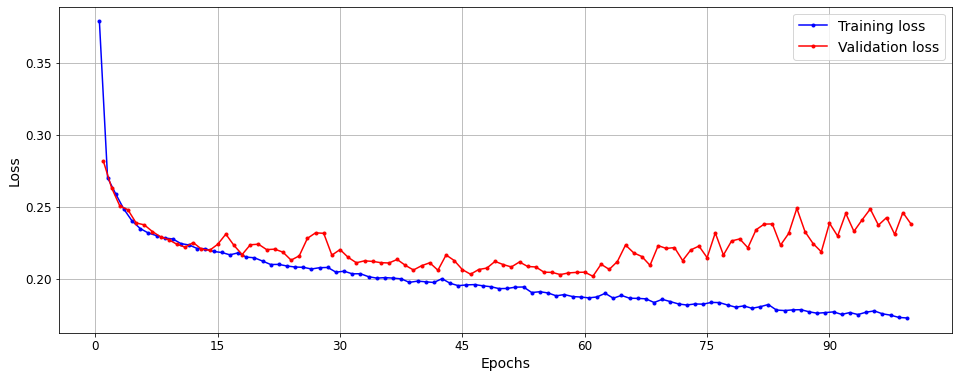

In [177]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

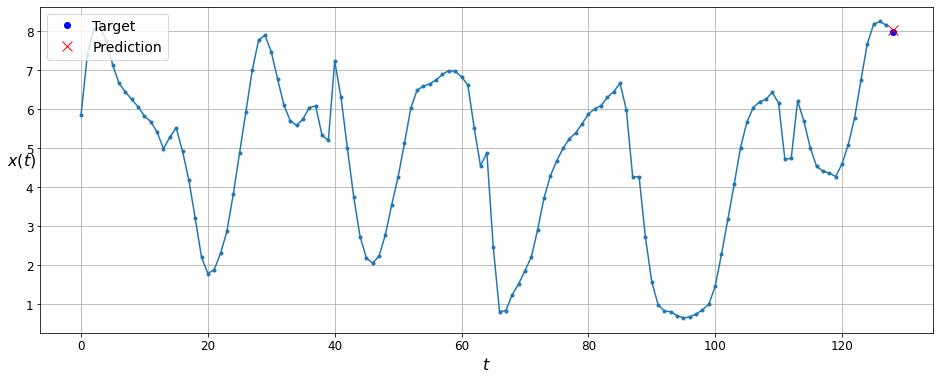

In [230]:
sample = 0
plt.figure(figsize=(16,6))
plot_series(X_test[sample, :, 0], Y_test[sample, 0], y_pred_Conv_GRU_Simple_128_Conv_encoder_32_16_1[sample, 0], n_steps=slide_timeStep)
plt.show()

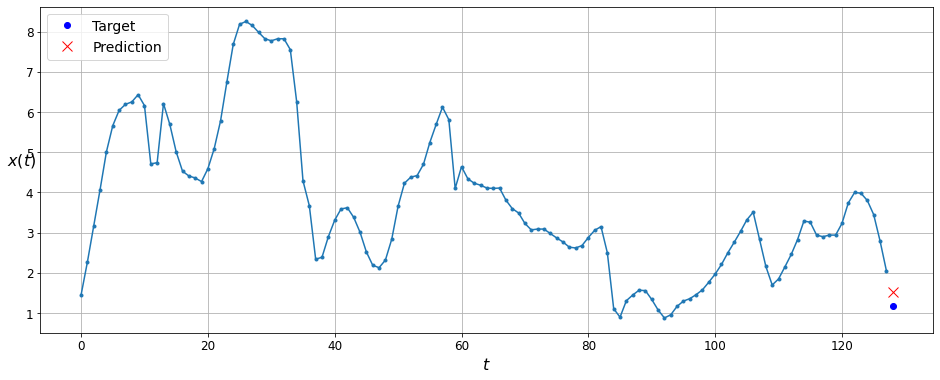

In [231]:
sample = 100
plt.figure(figsize=(16,6))
plot_series(X_test[sample, :, 0], Y_test[sample, 0],y_pred_Conv_GRU_Simple_128_Conv_encoder_32_16_1[sample, 0], n_steps=slide_timeStep)
plt.show()

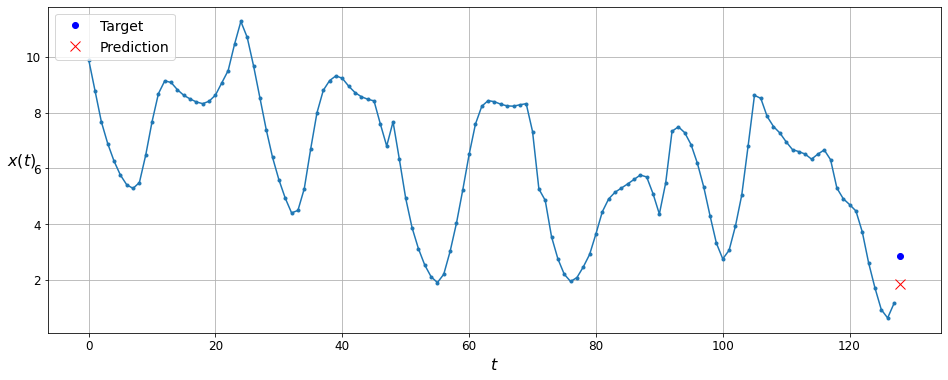

In [232]:
sample = 10000
plt.figure(figsize=(16,6))
plot_series(X_test[sample, :, 0], Y_test[sample, 0], y_pred_Conv_GRU_Simple_128_Conv_encoder_32_16_1[sample, 0], n_steps=slide_timeStep)
plt.show()

## GRU - Convulutional (CNN) with Average output layer: 

In [313]:
def MODEL_GRU_Simple_128_Conv_encoder_32_16_1_avg():
    input_shape = (slide_timeStep, num_features)
    Inputs = Input(input_shape, name='Input')
    
    gru = GRU(units=128, return_sequences=True)(Inputs)

    conv = Conv1D(32, kernel_size=3, activation="relu", padding='same')(gru)
    conv = Conv1D(16, kernel_size=3, activation="relu", padding='same')(conv)
    conv1 = Conv1D(1, kernel_size=1, activation="relu", padding='same')(conv)
    conv2 = Conv1D(1, kernel_size=1, activation="relu", padding='same')(conv)
    conv3 = Conv1D(1, kernel_size=1, activation="relu", padding='same')(conv)
    
    cropp_layer1 = Cropping1D(cropping=(slide_timeStep-1,0))(conv1)
    cropp_layer2 = Cropping1D(cropping=(slide_timeStep-1,0))(conv2)
    cropp_layer3 = Cropping1D(cropping=(slide_timeStep-1,0))(conv3)
    
    output1 = Reshape((-1,))(cropp_layer1)
    output2 = Reshape((-1,))(cropp_layer2)
    output3 = Reshape((-1,))(cropp_layer3)

    output0 = Average(name='output0')([output1,
                                       output2,
                                       output3])
    
    #output = [output0, output1, output2, output3]
    
    return Model(Inputs, output0)

In [314]:
model = MODEL_GRU_Simple_128_Conv_encoder_32_16_1_avg()

In [316]:
name_model = 'GRU_Simple_128_Conv_encoder_32_16_1_avg'

history = train_model(model, name_model)#, name_monitor='val_output0_mape')
model_Conv_GRU_Simple_128_Conv_encoder_32_16_1_avg = tf.keras.models.load_model('C:/Users/choco/OneDrive/DARIO Computador/UnB/Artigos/U-LSTM-NET/models_notebook/'+name_model+'.h5', compile=False)
model_Conv_GRU_Simple_128_Conv_encoder_32_16_1_avg.compile(loss="mae", optimizer="adam", metrics=['mse','mae', 'mape', tfa.metrics.r_square.RSquare()])
model_Conv_GRU_Simple_128_Conv_encoder_32_16_1_avg.evaluate(Inputs_test, targets_test)

logs\GRU_Simple_128_Conv_encoder_32_16_1_avg\20241212-160943
Epoch 1/50
311/313 [============================>.] - ETA: 0s - loss: 0.1991 - mse: 0.1057 - mae: 0.1991 - mape: 6.5559 - r_square: 0.9778
Epoch 1: val_mape improved from inf to 7.46040, saving model to C:/Users/choco/OneDrive/DARIO Computador/UnB/Artigos/U-LSTM-NET/models_notebook\GRU_Simple_128_Conv_encoder_32_16_1_avg.h5
313/313 [==============================] - 8s 22ms/step - loss: 0.1991 - mse: 0.1057 - mae: 0.1991 - mape: 6.5573 - r_square: 0.9778 - val_loss: 0.2184 - val_mse: 0.1150 - val_mae: 0.2184 - val_mape: 7.4604 - val_r_square: 0.9753
Epoch 2/50
310/313 [============================>.] - ETA: 0s - loss: 0.2005 - mse: 0.1057 - mae: 0.2005 - mape: 6.6086 - r_square: 0.9779
Epoch 2: val_mape did not improve from 7.46040
313/313 [==============================] - 7s 21ms/step - loss: 0.2005 - mse: 0.1059 - mae: 0.2005 - mape: 6.6026 - r_square: 0.9778 - val_loss: 0.2283 - val_mse: 0.1219 - val_mae: 0.2283 - val_map

[0.2019789069890976,
 0.10795733332633972,
 0.2019789069890976,
 7.56546688079834,
 0.9773033857345581]

In [256]:
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 128, 1)]     0           []                               
                                                                                                  
 gru_52 (GRU)                   (None, 128, 128)     50304       ['Input[0][0]']                  
                                                                                                  
 conv1d_111 (Conv1D)            (None, 128, 32)      12320       ['gru_52[0][0]']                 
                                                                                                  
 conv1d_112 (Conv1D)            (None, 128, 16)      1552        ['conv1d_111[0][0]']             
                                                                                           

## LSTM - CNN Model:

In [166]:
def MODEL_LSTM_Simple_128_Conv_encoder_32_16_1():
    input_shape = (slide_timeStep, num_features)
    Inputs = Input(input_shape, name='Input')
    
    lstm = LSTM(units=128, return_sequences=True)(Inputs)
    
    conv = Conv1D(32, kernel_size=1, activation="relu")(lstm)
    conv = Conv1D(16, kernel_size=1, activation="relu")(conv)
    conv = Conv1D(1,  kernel_size=1, activation="relu")(conv)
    
    cropp_layer = Cropping1D(cropping=(slide_timeStep-1,0))(conv)
    output = Reshape((-1,))(cropp_layer)

    return Model(Inputs, output)

In [168]:
model = MODEL_LSTM_Simple_128_Conv_encoder_32_16_1()

In [169]:
name_model = 'LSTM_Simple_128_Conv_encoder_32_16_1'

history = train_model(model, name_model, num_epoch=100)#, name_monitor='val_output0_mape')
model_LSTM_Simple_128_Conv_encoder_64_32_4_1 = tf.keras.models.load_model('C:/Users/choco/OneDrive/DARIO Computador/UnB/Artigos/U-LSTM-NET/models_notebook/'+name_model+'.h5', compile=False)
model_LSTM_Simple_128_Conv_encoder_64_32_4_1.compile(loss="mae", optimizer="adam", metrics=['mse','mae', 'mape', tfa.metrics.r_square.RSquare()])
model_LSTM_Simple_128_Conv_encoder_64_32_4_1.evaluate(Inputs_test, targets_test)

logs\LSTM_Simple_128_Conv_encoder_32_16_1\20241213-124210
Epoch 1/100
623/625 [============================>.] - ETA: 0s - loss: 0.4402 - mse: 0.5634 - mae: 0.4402 - mape: 14.0260 - r_square: 0.8819
Epoch 1: val_mape improved from inf to 9.69941, saving model to C:/Users/choco/OneDrive/DARIO Computador/UnB/Artigos/U-LSTM-NET/models_notebook\LSTM_Simple_128_Conv_encoder_32_16_1.h5
625/625 [==============================] - 15s 21ms/step - loss: 0.4398 - mse: 0.5626 - mae: 0.4398 - mape: 14.0196 - r_square: 0.8820 - val_loss: 0.2999 - val_mse: 0.2259 - val_mae: 0.2999 - val_mape: 9.6994 - val_r_square: 0.9515
Epoch 2/100
624/625 [============================>.] - ETA: 0s - loss: 0.2693 - mse: 0.1987 - mae: 0.2693 - mape: 8.3717 - r_square: 0.9583
Epoch 2: val_mape improved from 9.69941 to 9.00659, saving model to C:/Users/choco/OneDrive/DARIO Computador/UnB/Artigos/U-LSTM-NET/models_notebook\LSTM_Simple_128_Conv_encoder_32_16_1.h5
625/625 [==============================] - 13s 20ms/step 

[0.2001994401216507,
 0.10822290182113647,
 0.2001994401216507,
 7.438447952270508,
 0.9772475361824036]

## GRU with Stationary Wavelet and Derivative Attention Layers:

In [446]:
# Derivative-based Attention Mechanism
class DerivativeAttention(Layer):
    def __init__(self, **kwargs):
        super(DerivativeAttention, self).__init__(**kwargs)

    def call(self, inputs):
        # Calculate the derivative
        derivative = tf.abs(inputs[:, 1:] - inputs[:, :-1])
        # Add a zero at the beginning to keep the size (128, 1)
        derivative = tf.concat([tf.zeros((tf.shape(derivative)[0], 1, tf.shape(derivative)[-1])), derivative], axis=1)
        
        # Calculate attention weights using softmax
        attention_weights = tf.nn.softmax(derivative, axis=1)
        
        # Apply attention weights to inputs
        attended_inputs = inputs * attention_weights
        
        return attended_inputs, attention_weights

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = super().get_config()
        return config

# Custom layer for Wavelet Stationary
import tensorflow as tf
from tensorflow.keras.layers import Layer

class WaveletDecomposition(Layer):
    def __init__(self, wavelet_length=6, **kwargs):
        super(WaveletDecomposition, self).__init__(**kwargs)
        self.wavelet_length = wavelet_length

        # Initial wavelet coefficients db3
        base_lo = [-0.0352262918857,  0.0854412738822, -0.135011020010, -0.459877502118, 
                   0.806891509313, -0.332670552950]
        base_hi = [-0.332670552950, -0.806891509313, -0.459877502118,  0.135011020010, 
                   0.0854412738822,  0.0352262918857]

        # Adds zeros between coefficients for stationary wavelets
        self.dec_lo = self._add_zeros(base_lo, wavelet_length)
        self.dec_hi = self._add_zeros(base_hi, wavelet_length)

    def build(self, input_shape):
        # Converting EagerTensors para numpy.ndarray
        dec_lo_numpy = self.dec_lo.numpy()
        dec_hi_numpy = self.dec_hi.numpy()

        # Makes filters trainable
        self.dec_lo = self.add_weight(name='dec_lo', shape=dec_lo_numpy.shape, initializer=tf.constant_initializer(dec_lo_numpy), trainable=True)
        self.dec_hi = self.add_weight(name='dec_hi', shape=dec_hi_numpy.shape, initializer=tf.constant_initializer(dec_hi_numpy), trainable=True)
        super(WaveletDecomposition, self).build(input_shape)

    def _add_zeros(self, base_filter, length):
        """Insere zeros entre coeficientes."""
        extended_filter = []
        for coef in base_filter:
            extended_filter.append(coef)
            extended_filter.extend([0] * (length - 1))  # Adiciona zeros
        return tf.convert_to_tensor(extended_filter, dtype=tf.float32)

    def call(self, inputs):
        # Expansion to 4D (batch, width, channels, depth)
        inputs = tf.expand_dims(inputs, axis=-1)
        trends, details = [], []

        x = inputs
        for _ in range(3):  # Levels
            trend = tf.nn.conv2d(x, self.dec_lo[:, None, None, None], strides=1, padding='SAME')
            detail = tf.nn.conv2d(x, self.dec_hi[:, None, None, None], strides=1, padding='SAME')
            
            trends.append(tf.squeeze(trend, axis=-1))
            details.append(tf.squeeze(detail, axis=-1))
            x = trend  # Take the trend to the next level

        trend0 = trends[0]
        trend1 = trends[1]
        trend2 = trends[2]
        detail0 = details[0]
        detail1 = details[1]
        detail2 = details[2]
            
        return trend0, trend1, trend2, detail0, detail1, detail2

    def compute_output_shape(self, input_shape):
        output_shape = (input_shape[0], input_shape[1], input_shape[2])
        return [output_shape, output_shape, output_shape, output_shape, output_shape, output_shape]

    def get_config(self):
        config = super().get_config()
        config.update({
            "wavelet_length": self.wavelet_length,
        })
        return config

In [465]:
# GRU with Stationary Wavelet and Derivative Attention Layers Model
def MODEL_GRU_Wavelet():
    input_shape = (slide_timeStep, num_features)
    Inputs = Input(input_shape, name='Input')
    
    attended_inputs, attention_weights = DerivativeAttention()(Inputs)
    trend0, trend1, trend2, detail0, detail1, detail2 = WaveletDecomposition()(Inputs)
    
    combined_inputs = Concatenate()([Inputs, attention_weights, trend0, trend1, trend2,  detail1, detail2])
    
    gru = GRU(128, return_sequences=True)(combined_inputs)
    
    conv = Conv1D(32, kernel_size=3, activation="relu", name='conv1', padding = 'same')(gru)
    conv = Conv1D(16, kernel_size=3, activation="relu", name='conv2', padding = 'same')(conv)
    conv = Conv1D(1,  kernel_size=3, activation="relu", name='conv3', padding = 'same')(conv)
    
    cropp_layer = Cropping1D(cropping=(slide_timeStep-1,0))(conv)
    output = Reshape((-1,))(cropp_layer)

    model = Model(inputs=Inputs, outputs=output)
    return model

In [466]:
model = MODEL_GRU_Wavelet()
model.summary()

Model: "model_74"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 128, 1)]     0           []                               
                                                                                                  
 derivative_attention_86 (Deriv  ((None, 128, 1),    0           ['Input[0][0]']                  
 ativeAttention)                 (None, 128, 1))                                                  
                                                                                                  
 wavelet_decomposition_84 (Wave  ((None, 128, 1),    72          ['Input[0][0]']                  
 letDecomposition)               (None, 128, 1),                                                  
                                 (None, 128, 1),                                           

In [467]:
name_model = 'GRU_Wavelet01'

history = train_model(model, name_model, num_epoch=150)#, name_monitor='val_output0_mape')
model_GRU_Wavelet = tf.keras.models.load_model('C:/Users/choco/OneDrive/DARIO Computador/UnB/Artigos/U-LSTM-NET/models_notebook/'
                                               +name_model+'.h5', 
                                               custom_objects={'DerivativeAttention': DerivativeAttention, 
                                                               'WaveletDecomposition': WaveletDecomposition},
                                               compile=False)
model_GRU_Wavelet.compile(loss="mae", optimizer="adam", metrics=['mse','mae', 'mape', tfa.metrics.r_square.RSquare()])
model_GRU_Wavelet.evaluate(X_test, Y_test)

Epoch 1/150
624/625 [============================>.] - ETA: 0s - loss: 0.3695 - mse: 0.4148 - mae: 0.3695 - mape: 11.3983 - r_square: 0.9130
Epoch 1: val_mape improved from inf to 9.40183, saving model to C:/Users/choco/OneDrive/DARIO Computador/UnB/Artigos/U-LSTM-NET/models_notebook\GRU_Wavelet01.h5
625/625 [==============================] - 17s 22ms/step - loss: 0.3695 - mse: 0.4148 - mae: 0.3695 - mape: 11.3975 - r_square: 0.9130 - val_loss: 0.2771 - val_mse: 0.1976 - val_mae: 0.2771 - val_mape: 9.4018 - val_r_square: 0.9576
Epoch 2/150
624/625 [============================>.] - ETA: 0s - loss: 0.2578 - mse: 0.1796 - mae: 0.2578 - mape: 7.9924 - r_square: 0.9623
Epoch 2: val_mape improved from 9.40183 to 8.59849, saving model to C:/Users/choco/OneDrive/DARIO Computador/UnB/Artigos/U-LSTM-NET/models_notebook\GRU_Wavelet01.h5
625/625 [==============================] - 14s 22ms/step - loss: 0.2577 - mse: 0.1796 - mae: 0.2577 - mape: 7.9921 - r_square: 0.9623 - val_loss: 0.2507 - val_ms

[0.20892730355262756,
 0.11729347705841064,
 0.20892730355262756,
 7.936068058013916,
 0.9753406047821045]

# Multivariate GRU - CNN Forescating 

In this section we use the GRU-CNN model (input of 128 samples, 128 GRU unit followed by 3 convolutional 1D layers of 32, 16 and 1 filter with a kernel of 1). This model showed the best performance in the previous section and is therefore the one chosen to carry out a multivariable analysis.

## Dataset preprocesing multivariate

The wind direction must be decomposed using the sine and cosine of the direction in degrees or radians, to avoid the discontinuity between 360 and 0. Working with these two components creates two continuous inputs that vary between 0 and 1 and unequivocally identify the wind direction for the network.

In [ ]:
# Grouping 
# "Wind Speed", "Wind Direction",
ws_meanxhora = ap_data['Wind Speed'].groupby([ap_data.Year, ap_data.Month, ap_data.Day, ap_data.Hour]).mean().to_frame()
ws_meanxhora.loc[:,'Wind Direction'] = ap_data['Wind Direction'].groupby([ap_data.Year, ap_data.Month, ap_data.Day, ap_data.Hour]).mean().to_frame()
ws_meanxhora.loc[:,'Wind Dir Sin'] = sind(ap_data['Wind Direction']).groupby([ap_data.Year, ap_data.Month, ap_data.Day, ap_data.Hour]).mean().to_frame()
ws_meanxhora.loc[:,'Wind Dir Cos'] = cosd(ap_data['Wind Direction']).groupby([ap_data.Year, ap_data.Month, ap_data.Day, ap_data.Hour]).mean().to_frame()
ws_meanxhora.loc[:,'PS'] = ap_data['PS'].groupby([ap_data.Year, ap_data.Month, ap_data.Day, ap_data.Hour]).mean().to_frame()
ws_meanxhora.loc[:,'Temp_2m'] = ap_data['Temp_2m'].groupby([ap_data.Year, ap_data.Month, ap_data.Day, ap_data.Hour]).mean().to_frame()
ws_meanxhora.loc[:,'ALLSKY'] = ap_data['ALLSKY'].groupby([ap_data.Year, ap_data.Month, ap_data.Day, ap_data.Hour]).mean().to_frame()

samples = len(ws_meanxhora)
slide_timeStep = 128
num_features = 3
 
data = np.array(ws_meanxhora[["Wind Speed", 'Wind Dir Sin', 'Wind Dir Cos'])#, 'ALLSKY', 'Temp_2m', 'PS']])
#Data_set 
data_set = np.array([data[i:i+slide_timeStep] for i in range(samples-slide_timeStep)])
#Targets
target_set = data[slide_timeStep:][:, 0]

Inputs_train, Inputs_test, targets_train, targets_test =\
                        train_test_split(data_set, target_set, test_size=0.10, 
                        shuffle=False, random_state=None)
                        
Inputs_train, Inputs_val, targets_train, targets_val =\
                        train_test_split(Inputs_train, targets_train, test_size=0.20, 
                        shuffle=False, random_state=None)                        
                        
X_train, Y_train = Inputs_train, targets_train.reshape(-1,1)  
X_val, Y_val = Inputs_val, targets_val.reshape(-1,1)
X_test, Y_test = Inputs_test, targets_test.reshape(-1,1)

The following hybrid model uses 3 characteristics as inputs, the wind speed, the sine and cosine of the wind direction, and as can be seen, the forecast improves considerably compared to that obtained with the same model using only the wind speed as an input characteristic.

In [519]:
def MODEL_GRU_128_Conv_32_16_1_Multivariate():
    input_shape = (slide_timeStep, num_features)
    Inputs = Input(input_shape, name='Input')
    
    gru = GRU(units=64, return_sequences=True)(Inputs)
    
    gru = GRU(units=32, return_sequences=True)(gru)

    conv = Conv1D(32, kernel_size=1, activation="relu", padding='same')(gru)
    conv = Conv1D(16, kernel_size=1, activation="relu", padding='same')(conv)
    conv = Conv1D(1, kernel_size=1, activation="relu", padding='same')(conv)
    
    cropp_layer = Cropping1D(cropping=(slide_timeStep-1, 0))(conv)
    
    output = Reshape((-1,))(cropp_layer)

    return Model(Inputs, output)

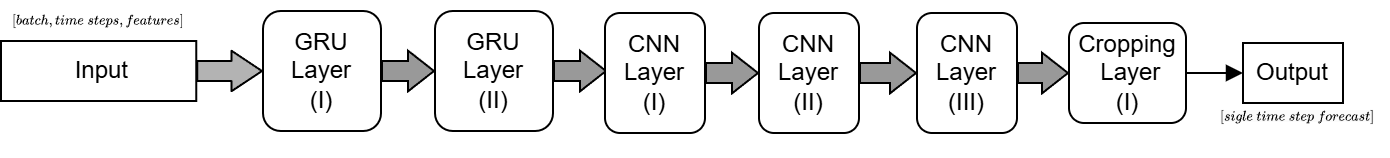

In [76]:
from IPython.display import Image, display
# Path to the image
image_path = "C:/Users/choco/OneDrive/DARIO Computador/UnB/Artigos/U-LSTM-NET/imagens/GRU_CNN_Model.png"
# Display the image
display(Image(filename=image_path))

In [520]:
model = MODEL_GRU_128_Conv_32_16_1_Multivariate()
model.summary()

Model: "model_84"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 128, 3)]          0         
                                                                 
 gru_105 (GRU)               (None, 128, 64)           13248     
                                                                 
 gru_106 (GRU)               (None, 128, 32)           9408      
                                                                 
 conv1d_182 (Conv1D)         (None, 128, 32)           1056      
                                                                 
 conv1d_183 (Conv1D)         (None, 128, 16)           528       
                                                                 
 conv1d_184 (Conv1D)         (None, 128, 1)            17        
                                                                 
 cropping1d_91 (Cropping1D)  (None, 1, 1)              0  

In [521]:
name_model = 'GRU_128_Conv_32_16_1_Multivariate'

history = train_model(model, name_model, num_epoch=100)#, name_monitor='val_output0_mape')
model_GRU_128_Conv_32_16_1_Multivariate = tf.keras.models.load_model('C:/Users/choco/OneDrive/DARIO Computador/UnB/Artigos/U-LSTM-NET/models_notebook/'
                                                                    +name_model+'.h5', compile=False)
model_GRU_128_Conv_32_16_1_Multivariate.compile(loss="mae", optimizer="adam", metrics=['mse','mae', 'mape', tfa.metrics.r_square.RSquare()])
model_GRU_128_Conv_32_16_1_Multivariate.evaluate(X_test, Y_test)

Epoch 1/100
749/749 [==============================] - ETA: 0s - loss: 0.5491 - mse: 1.1677 - mae: 0.5491 - mape: 16.1889 - r_square: 0.7569
Epoch 1: val_mape improved from inf to 9.30042, saving model to C:/Users/choco/OneDrive/DARIO Computador/UnB/Artigos/U-LSTM-NET/models_notebook\GRU_128_Conv_32_16_1_Multivariate.h5
749/749 [==============================] - 28s 33ms/step - loss: 0.5491 - mse: 1.1677 - mae: 0.5491 - mape: 16.1889 - r_square: 0.7569 - val_loss: 0.3114 - val_mse: 0.2469 - val_mae: 0.3114 - val_mape: 9.3004 - val_r_square: 0.9496
Epoch 2/100
749/749 [==============================] - ETA: 0s - loss: 0.2683 - mse: 0.1995 - mae: 0.2683 - mape: 8.3720 - r_square: 0.9585
Epoch 2: val_mape improved from 9.30042 to 8.76516, saving model to C:/Users/choco/OneDrive/DARIO Computador/UnB/Artigos/U-LSTM-NET/models_notebook\GRU_128_Conv_32_16_1_Multivariate.h5
749/749 [==============================] - 29s 39ms/step - loss: 0.2683 - mse: 0.1995 - mae: 0.2683 - mape: 8.3720 - r_sq

[0.1928435117006302,
 0.10451138764619827,
 0.1928435117006302,
 6.31271505355835,
 0.9768979549407959]

Now is used the previous model with 6 input features.

In [17]:
# Grouping 
# "Wind Speed", "Wind Direction","Temp_2m", "ALLSKY", "PS"
ws_meanxhora = ap_data['Wind Speed'].groupby([ap_data.Year, ap_data.Month, ap_data.Day, ap_data.Hour]).mean().to_frame()
ws_meanxhora.loc[:,'Wind Direction'] = ap_data['Wind Direction'].groupby([ap_data.Year, ap_data.Month, ap_data.Day, ap_data.Hour]).mean().to_frame()
ws_meanxhora.loc[:,'Wind Dir Sin'] = sind(ap_data['Wind Direction']).groupby([ap_data.Year, ap_data.Month, ap_data.Day, ap_data.Hour]).mean().to_frame()
ws_meanxhora.loc[:,'Wind Dir Cos'] = cosd(ap_data['Wind Direction']).groupby([ap_data.Year, ap_data.Month, ap_data.Day, ap_data.Hour]).mean().to_frame()
ws_meanxhora.loc[:,'PS'] = ap_data['PS'].groupby([ap_data.Year, ap_data.Month, ap_data.Day, ap_data.Hour]).mean().to_frame()
ws_meanxhora.loc[:,'Temp_2m'] = ap_data['Temp_2m'].groupby([ap_data.Year, ap_data.Month, ap_data.Day, ap_data.Hour]).mean().to_frame()
ws_meanxhora.loc[:,'ALLSKY'] = ap_data['ALLSKY'].groupby([ap_data.Year, ap_data.Month, ap_data.Day, ap_data.Hour]).mean().to_frame()

samples = len(ws_meanxhora)
slide_timeStep = 128
num_features = 6
 
data = np.array(ws_meanxhora[["Wind Speed", 'Wind Dir Sin', 'Wind Dir Cos', 'ALLSKY', 'Temp_2m', 'PS']])
#Data_set 
data_set = np.array([data[i:i+slide_timeStep] for i in range(samples-slide_timeStep)])
#Targets
target_set = data[slide_timeStep:][:, 0]

Inputs_train, Inputs_test, targets_train, targets_test =\
                        train_test_split(data_set, target_set, test_size=0.10, 
                        shuffle=False, random_state=None)
                        
Inputs_train, Inputs_val, targets_train, targets_val =\
                        train_test_split(Inputs_train, targets_train, test_size=0.20, 
                        shuffle=False, random_state=None)                        
                        
X_train, Y_train = Inputs_train, targets_train.reshape(-1,1)  
X_val, Y_val = Inputs_val, targets_val.reshape(-1,1)
X_test, Y_test = Inputs_test, targets_test.reshape(-1,1)

In [18]:
def MODEL_GRU_64_32_CNN_32_16_1_Multivariate():
    input_shape = (slide_timeStep, num_features)
    Inputs = Input(input_shape, name='Input')
    
    gru = GRU(units=64, return_sequences=True)(Inputs)
    
    gru = GRU(units=32, return_sequences=True)(gru)

    conv = Conv1D(32, kernel_size=1, activation="relu", padding='same')(gru)
    conv = Conv1D(16, kernel_size=1, activation="relu", padding='same')(conv)
    conv = Conv1D(1, kernel_size=1, activation="relu", padding='same')(conv)
    
    cropp_layer = Cropping1D(cropping=(slide_timeStep-1, 0))(conv)
    
    output = Reshape((-1,))(cropp_layer)
    
    return Model(Inputs, output)

In [21]:
model = MODEL_GRU_64_32_CNN_32_16_1_Multivariate()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 128, 6)]          0         
                                                                 
 gru_5 (GRU)                 (None, 128, 64)           13824     
                                                                 
 gru_6 (GRU)                 (None, 128, 32)           9408      
                                                                 
 conv1d_3 (Conv1D)           (None, 128, 32)           1056      
                                                                 
 conv1d_4 (Conv1D)           (None, 128, 16)           528       
                                                                 
 conv1d_5 (Conv1D)           (None, 128, 1)            17        
                                                                 
 cropping1d_1 (Cropping1D)   (None, 1, 1)              0   

In [22]:
name_model = 'GRU_64_32_CNN_32_16_1_Multivariate'

history = train_model(model, name_model, num_epoch=100)#, name_monitor='val_output0_mape')
MODEL_GRU_64_32_CNN_32_16_1_Multivariate = tf.keras.models.load_model('C:/Users/choco/OneDrive/DARIO Computador/UnB/Artigos/U-LSTM-NET/models_notebook/'
                                                                    +name_model+'.h5', compile=False)
MODEL_GRU_64_32_CNN_32_16_1_Multivariate.compile(loss="mae", optimizer="adam", metrics=['mse','mae', 'mape', tfa.metrics.r_square.RSquare()])
MODEL_GRU_64_32_CNN_32_16_1_Multivariate.evaluate(X_test, Y_test)

Epoch 1/100
748/749 [============================>.] - ETA: 0s - loss: 1.5457 - mse: 3.8471 - mae: 1.5457 - mape: 59.8361 - r_square: 0.1991
Epoch 1: val_mape improved from inf to 34.83958, saving model to C:/Users/choco/OneDrive/DARIO Computador/UnB/Artigos/U-LSTM-NET/models_notebook\GRU_64_32_CNN_32_16_1_Multivariate.h5
749/749 [==============================] - 21s 25ms/step - loss: 1.5447 - mse: 3.8434 - mae: 1.5447 - mape: 59.8118 - r_square: 0.1997 - val_loss: 0.8585 - val_mse: 1.4390 - val_mae: 0.8585 - val_mape: 34.8396 - val_r_square: 0.7062
Epoch 2/100
747/749 [============================>.] - ETA: 0s - loss: 0.6149 - mse: 0.7615 - mae: 0.6149 - mape: 23.4286 - r_square: 0.8415
Epoch 2: val_mape improved from 34.83958 to 17.23549, saving model to C:/Users/choco/OneDrive/DARIO Computador/UnB/Artigos/U-LSTM-NET/models_notebook\GRU_64_32_CNN_32_16_1_Multivariate.h5
749/749 [==============================] - 19s 25ms/step - loss: 0.6143 - mse: 0.7603 - mae: 0.6143 - mape: 23.413

[0.22010450065135956,
 0.13286952674388885,
 0.22010450065135956,
 7.877710342407227,
 0.9706294536590576]

## Multivariate inputs in model deep GRU model with Dense NN output:

In [24]:
def MODEL_GRU_64_32_Dense_256_128_64_1_Multivariate():
    input_shape = (slide_timeStep, num_features)
    Inputs = Input(input_shape, name='Input')
    
    gru = GRU(units=64, return_sequences=True)(Inputs)
    
    gru = GRU(units=32, return_sequences=False)(gru)

   #conv = Conv1D(32, kernel_size=1, activation="relu", padding='same')(gru)
   #conv = Conv1D(16, kernel_size=1, activation="relu", padding='same')(conv)
   #conv = Conv1D(1, kernel_size=1, activation="relu", padding='same')(conv)
   #
   #cropp_layer = Cropping1D(cropping=(slide_timeStep-1, 0))(conv)
   #
   #output = Reshape((-1,))(cropp_layer)
    dense_1 = Dense(256, activation="relu")(gru)
    dense_2 = Dense(128, activation="relu")(dense_1)
    dense_3 = Dense(64,  activation="relu")(dense_2)
    output= Dense(1,   activation="relu")(dense_3)
    

    return Model(Inputs, output)

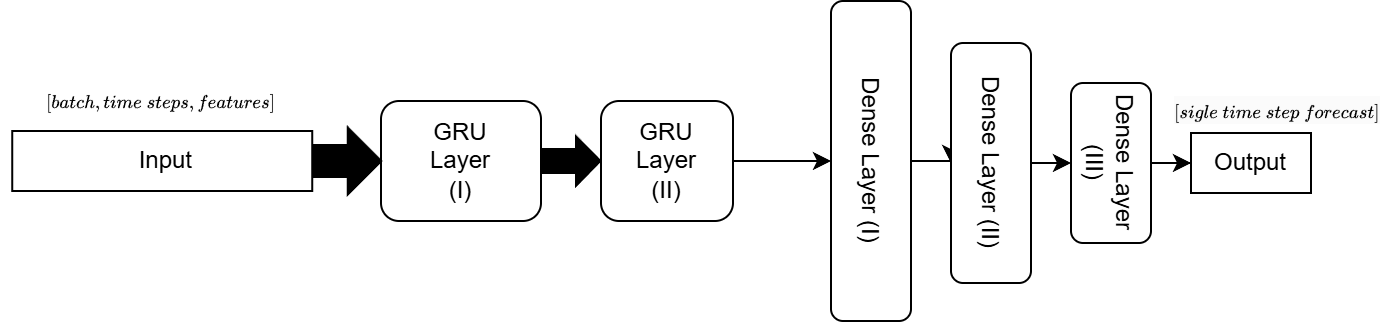

In [27]:
# Path to the image
image_path = "C:/Users/choco/OneDrive/DARIO Computador/UnB/Artigos/U-LSTM-NET/imagens/GRU_Dense_Model.png"
# Display the image
display(Image(filename=image_path))

In [28]:
model = MODEL_GRU_64_32_Dense_256_128_64_1_Multivariate()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 128, 6)]          0         
                                                                 
 gru_7 (GRU)                 (None, 128, 64)           13824     
                                                                 
 gru_8 (GRU)                 (None, 32)                9408      
                                                                 
 dense_4 (Dense)             (None, 256)               8448      
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 1)                 65  

In [29]:
name_model = 'GRU_64_32_Dense_256_128_64_1_Multivariate'

history = train_model(model, name_model, num_epoch=100)#, name_monitor='val_output0_mape')
MODEL_GRU_64_32_Dense_256_128_64_1_Multivariate = tf.keras.models.load_model('C:/Users/choco/OneDrive/DARIO Computador'+
                                                 '/UnB/Artigos/U-LSTM-NET/models_notebook/'
                                                 +name_model+'.h5', compile=False)
MODEL_GRU_64_32_Dense_256_128_64_1_Multivariate.compile(loss="mae", optimizer="adam", 
                                                        metrics=['mse','mae', 'mape', tfa.metrics.r_square.RSquare()])
MODEL_GRU_64_32_Dense_256_128_64_1_Multivariate.evaluate(X_test, Y_test)

Epoch 1/100
749/749 [==============================] - ETA: 0s - loss: 1.3086 - mse: 2.9339 - mae: 1.3086 - mape: 52.0853 - r_square: 0.3891
Epoch 1: val_mape improved from inf to 34.46304, saving model to C:/Users/choco/OneDrive/DARIO Computador/UnB/Artigos/U-LSTM-NET/models_notebook\GRU_64_32_Dense_256_128_64_1_Multivariate.h5
749/749 [==============================] - 26s 33ms/step - loss: 1.3086 - mse: 2.9339 - mae: 1.3086 - mape: 52.0853 - r_square: 0.3891 - val_loss: 0.8804 - val_mse: 1.6216 - val_mae: 0.8804 - val_mape: 34.4630 - val_r_square: 0.6690
Epoch 2/100
748/749 [============================>.] - ETA: 0s - loss: 0.7227 - mse: 1.0657 - mae: 0.7227 - mape: 28.7801 - r_square: 0.7781
Epoch 2: val_mape improved from 34.46304 to 17.64986, saving model to C:/Users/choco/OneDrive/DARIO Computador/UnB/Artigos/U-LSTM-NET/models_notebook\GRU_64_32_Dense_256_128_64_1_Multivariate.h5
749/749 [==============================] - 27s 36ms/step - loss: 0.7223 - mse: 1.0647 - mae: 0.7223 

[0.21417078375816345,
 0.11809764057397842,
 0.21417078375816345,
 8.137182235717773,
 0.9738947153091431]

# Conclusion

As evident from the last two models that were trained, the incorporation of variables such as temperature, global solar irradiance, and surface pressure did not result in an enhancement of the forecast. Rather, the incorporation resulted in an increase in training time and convergence time for optimal performance. Adding input variables can be equivalent to introducing noise into the system, making the model unable to learn or interpret these variables correctly. Analyses carried out but not presented show that the most relevant variable is wind direction whenever it is decomposed into sine and cosine. It was also observed in the first analyses that increasing the input time steps can improve the model's performance, although there is an optimum value which, according to our analysis, is between 96 and 128 input samples. This analysis will have to be carried out on a case-by-case basis, but these ranges of values where hourly averages are used allow us to detect daily seasonalities and trends associated with monthly seasonalities. Another important point confirmed by these analyses is the fact that complex models, such as the model using the stationary wavelet layer and derivative attention, or deeper models do not imply better performance.